In [ ]:
pip install aif360

     |████████████████████████████████| 175 kB 15.7 MB/s 
     |████████████████████████████████| 564 kB 36.5 MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=4303e609d6af405743f4efd71f8b692ac4e2e79b7998a23b04f2a52666e99427
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler


In [ ]:
import scipy.io
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tarfile
import aif360
import pickle

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
import seaborn as sns
sns.set();

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASETS = ['loan_defaults', 'adult', 'german_credit', 
            'communities_and_crime', 'student_performance', 'portuguese_marketing', 
            #'compas', 'meps', 
            #'framingham'
            ]

In [ ]:
def dataset_reader(dataset_name):
    
    if dataset_name == 'loan_defaults':
        # https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

        df = pd.read_excel('/content/drive/MyDrive/FairML/Datasets/Credit/credit_data.xls', skiprows=[0])
        df = df.drop(columns=['ID'])

    elif dataset_name == 'adult':
        # https://archive.ics.uci.edu/ml/datasets/adult

        df = pd.read_csv('/content/drive/MyDrive/FairML/Datasets/Adult/adult.csv')

    elif dataset_name == 'german_credit':
        # https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)

        german_columns_csv = ['Account Balance', 'Duration of Credit (month)',
              'Payment Status of Previous Credit', 'Purpose', 'Credit Amount',
              'Value Savings/Stocks', 'Length of current employment',
              'Instalment per cent', 'Sex & Marital Status', 'Guarantors',
              'Duration in Current address', 'Most valuable available asset',
              'Age (years)', 'Concurrent Credits', 'Type of apartment',
              'No of Credits at this Bank', 'Occupation', 'No of dependents',
              'Telephone', 'Foreign Worker', 'Creditability']
        df = pd.read_csv('/content/drive/MyDrive/FairML/Datasets/German/german.data', delim_whitespace=True, header=None)
        df.columns = german_columns_csv
        # extra mapping
        sex_and_marital_map = {'A91':'Male', 'A93':'Male', 'A94':'Male', 'A92':'Female', 'A95':'Female'}
        df['Sex & Marital Status'] = df['Sex & Marital Status'].map(sex_and_marital_map)
        df.rename({'Sex & Marital Status': 'Sex'}, axis=1, inplace=True)


        #df = pd.read_csv('/content/drive/MyDrive/FairML/Datasets/German/german_credit.csv')

    elif dataset_name == 'communities_and_crime':
        # http://archive.ics.uci.edu/ml/datasets/communities+and+crime

        with open('/content/drive/MyDrive/FairML/Datasets/Communities_and_Crime/communities.names') as f:
            colnames = []
            for line in f.readlines():
                if line[:10] == '@attribute':
                  colnames.append(line.split(' ')[1])
        
        df = pd.read_csv('/content/drive/MyDrive/FairML/Datasets/Communities_and_Crime/communities.data', header=None)
        df.columns = colnames
        df.drop(['state', 'county', 'community', 'communityname', 'fold'], axis=1, inplace=True)
        
    elif dataset_name == 'portuguese_marketing':
        # https://archive.ics.uci.edu/ml/datasets/bank+marketing
        df = pd.read_csv('/content/drive/MyDrive/FairML/Datasets/PortugueseBankMarketing/bank/bank-full.csv', sep=';')

    elif dataset_name == 'student_performance':
        # https://archive.ics.uci.edu/ml/datasets/student+performance
        df = pd.read_csv('/content/drive/MyDrive/FairML/Datasets/Student_Performance/student-por.csv', sep=';')
    
    elif dataset_name == 'compas':
        # https://github.com/propublica/compas-analysis
        df = pd.read_csv('/content/drive/MyDrive/FairML/Datasets/COMPAS/compas-scores-two-years.csv')
    
    elif dataset_name == 'framingham':
        raise NotImplementedError('Need to find data')

    elif dataset_name == 'meps':
        # https://github.com/Trusted-AI/AIF360/tree/master/aif360/data/raw/meps
        target_path = '/usr/local/lib/python3.7/dist-packages/aif360/data/raw/meps'
        source_path = '/content/drive/MyDrive/FairML/Datasets/MEPS'
        from shutil import copyfile
        if not os.path.exists(os.path.join(target_path, 'h181.csv')):
            copyfile(os.path.join(source_path,'h181.csv'), os.path.join(target_path, 'h181.csv'))
        
        if not os.path.exists(os.path.join(target_path, 'h192.csv')):
            copyfile(os.path.join(source_path,'h192.csv'), os.path.join(target_path, 'h192.csv'))

        # Datasets
        from aif360.datasets import MEPSDataset19
        df = MEPSDataset19().convert_to_dataframe()[0]

    else:
       raise ValueError('Does not yet support this dataset {}'.format(dataset_name))
    
    df = df.reset_index(drop=True)
    return df

In [ ]:
def preprocess_dataset(dataset_name, drop=False):

    data = dataset_reader(dataset_name)
    cols_dict = {k : v for k,v in data.dtypes.to_dict().items() if v == np.dtype('O')}

    object_cols = sorted([x for x in cols_dict.keys()])
    value_cols = sorted([x for x in data.columns if x not in object_cols])

    #object_cols = sorted([x for x in cols_dict.keys() if x not in protected_features])
    #value_cols = sorted([x for x in data.columns if (x not in object_cols) and (x not in protected_features)])
    #object_cols = [x for x in object_cols if x!=target_feature]
    #value_cols = [x for x in value_cols if x!=target_feature]

    data, drop_list = treat_missing_values(data, drop)
    if len(object_cols) > 0:
        ohe_data = customOneHotEncoding(data, object_cols, drop_list)
        comb_data = pd.concat([data[value_cols], ohe_data], axis=1)
    else:
        comb_data = data[value_cols]

    data = data.reset_index(drop=True)
    comb_data = comb_data.reset_index(drop=True)

    return data, comb_data

def treat_missing_values(data, drop=False):

    special_symbols = ['?']
    drop_list = []
    for col in data.columns:
        for sym in special_symbols:
            if (data[col] == sym).any():
                data[col] = data[col].map(lambda x: x.replace(sym, 'missing'))
                drop_list.append(col)

    if drop:
        data = data.dropna()
    else:
        data = data.fillna('missing')
    
    return data, drop_list


def customOneHotEncoding(data, object_cols, drop_cols):
    
    res = []
    for col in object_cols:
        if col in drop_cols:
            ohe = OneHotEncoder(sparse=False, drop=['missing'])
        else:
            ohe = OneHotEncoder(sparse=False, drop='first')

        temp = ohe.fit_transform(data[col].values.reshape(-1, 1))
        temp = pd.DataFrame(data=temp, columns=ohe.get_feature_names([col])) 
        res.append(temp)

    return pd.concat(res, axis=1)

In [ ]:
def protected_and_target_features(dataset_name):
    
    if dataset_name == 'adult':
        protected_features = ['gender']
        target_feature = 'income'

    elif dataset_name == 'loan_defaults':
        protected_features = ['SEX']
        target_feature = 'default payment next month'

    elif dataset_name == 'german_credit':
        protected_features = ['Sex']
        target_feature = 'Creditability'
    
    elif dataset_name == 'communities_and_crime':
        protected_features = ['racepctblack']
        target_feature = 'ViolentCrimesPerPop'

    elif dataset_name == 'student_performance':
        protected_features = ['sex']
        target_feature = 'G3'

    elif dataset_name == 'portuguese_marketing':
        protected_features = ['marital']
        target_feature = 'y'
    
    elif dataset_name == 'compas':
        raise ValueError("needs to be implemented")
    
    elif dataset_name == 'meps':
        raise ValueError("needs to be implemented")
    else:
        raise ValueError("No such data set")

    return protected_features, target_feature

In [ ]:
class Supervised_UL(object):
  
    def __init__(self, rank, dataset_name, method, test_size=0.2, downsample_ratio=None, seed=42):
        
        self.rank = rank
        self.dataset_name = dataset_name
        self.method = method
        self._scores = None
        self._data = None
        self._data_prep = None
        self._data_non_pred = None
        self._obj = None
        self.test_size = test_size
        self._train_idx = None
        self._test_idx = None
        self._scaler = StandardScaler()
        self._target = None
        self._protected = None
        self.N = None
        self.downsample_ratio = downsample_ratio
        self.seed=seed
    
    
    def downsample(self, data, comb_data):

        counts = data[self._protected].value_counts()
        class_name = counts[counts==counts.max()].index[0]
        class_count = counts[counts==counts.max()].values[0]
        opposite_class = counts[counts!=counts.max()].index[0]
        opposie_target_count = int(class_count/self.downsample_ratio)

        opp_indices = data[data[self._protected] == opposite_class].index
        rng = np.random.RandomState(self.seed)
        opp_down_indices = list(rng.choice(opp_indices, size=opposie_target_count, replace=False))
        final_indices = data[data[self._protected] == class_name].index.to_list() + opp_down_indices

        data_down = data.loc[final_indices]
        comb_data_down = comb_data.loc[final_indices]
        data_down = data_down.reset_index(drop=True)
        comb_data_down = comb_data_down.reset_index(drop=True)
        return data_down, comb_data_down


    def feature_scores(self):
        
        if self._protected is None:
            protected_features, self._target = protected_and_target_features(self.dataset_name)
            self._protected = protected_feature = protected_features[0]
        protected_feature = self._protected
        target_feature = self._target


        if self._data is None:
            data, processed_data = preprocess_dataset(self.dataset_name)

            if self.downsample_ratio is not None:
                self._data, self._data_prep = self.downsample(data, processed_data)
            else:
                self._data = data.copy()
                self._data_prep = processed_data.copy()
            self.N = self._data.shape[0]
        
        data = self._data.copy()
        data_prep = self._data_prep.copy()
        remaining_features = [x for x in data.columns if (x != protected_feature) and (x != target_feature)]

        if self._train_idx is None:
            self.train_test_split()
        
        self._scaler.fit(data_prep.loc[self._train_idx])
        self._scaled_data_prep = pd.DataFrame(data=self._scaler.transform(data_prep), columns=self._data_prep.columns)

        le = LabelEncoder()
        le.fit(data.loc[self._train_idx, protected_feature])
        Y = le.transform(data.loc[self._train_idx, protected_feature])
        Y_test = le.transform(data.loc[self._test_idx, protected_feature])


        scores = {}
        for feat in remaining_features:

            temp = [x for x in data_prep.columns if x.startswith(feat)]
            temp = temp[1:] if len(temp) > 1 else temp

            lr = LogisticRegression(max_iter=200)
            lr.fit(self._scaled_data_prep.loc[self._train_idx, temp], Y)
            Y_pred = lr.predict_proba(self._scaled_data_prep.loc[self._test_idx, temp])[:, 1]
            scores[feat] = roc_auc_score(Y_test, Y_pred)
        
        self._scores = scores
        return scores


    def find_predictive_features(self):
        
        if self._scores is None:
            scores = self.feature_scores()
        else:
            scores = self._scores
        
        # idea is to find two clusters
        scores_ = pd.Series(scores)
        km = KMeans(n_clusters=2)
        km.fit(scores_.values.reshape(-1, 1))
        high_score_cluster = np.argmax(km.cluster_centers_)
        predictive_features = scores_.index[np.where(km.labels_== high_score_cluster)[0]]

        return list(predictive_features)


    def fit(self):
        
        if self.method == 'PCA':
            obj = PCA(n_components=self.rank)
        elif self.method == 'KMeans':
            obj = KMeans(n_clusters=self.rank, n_init=1)
        else:
            raise ValueError('Not supported = {}'.format(self.method))

        predictive_features = self.find_predictive_features()
        # drop protected feature and target feature from object fitting
        predictive_features.extend([self._target, self._protected])
        self._data_non_pred = self._scaled_data_prep.copy()
        
        for feat in predictive_features:
            feat_cols = [x for x in self._data_prep.columns if x.startswith(feat)]
            self._data_non_pred.drop(columns=feat_cols, axis=1, inplace=True)

        obj.fit(self._data_non_pred.loc[self._train_idx])
        self._obj = obj
    
    
    def transform(self):
        
        return self._obj.transform(self._data_non_pred.loc[self._train_idx])

    
    def train_test_split(self):
        
        train_idx, test_idx = train_test_split(np.arange(self.N), test_size=self.test_size, shuffle=True, random_state=self.seed, stratify=self._data[self._protected])
        self._train_idx = train_idx
        self._test_idx = test_idx
 
    
    def score_non_supervised(self):

        resulting_scores = {}

        if self.method == 'KMeans':
            obj = KMeans(n_clusters=self.rank)
            drop_features = [self._target, self._protected]
            self._data_non_super = self._scaled_data_prep.copy()
            for feat in drop_features:
                feat_cols = [x for x in self._data_prep.columns if x.startswith(feat)]
                self._data_non_super.drop(columns=feat_cols, axis=1, inplace=True)
            
            obj.fit(self._data_non_super.loc[self._train_idx])
            self._obj_non_super = obj
            cc = obj.cluster_centers_
            adjusting_for_dim = self._data_non_super.shape[1] / self._data_non_pred.shape[1]
            
            resulting_scores['train'] = {}
            dist_tr = cdist(self._data_non_super.loc[self._train_idx], cc, 'sqeuclidean')
            dist_to_clusters = np.min(dist_tr, axis=1)

            groups = sorted(self._data.loc[self._train_idx, self._protected].unique()) 
            for j, val in enumerate(groups):
                
                mask = self._data.loc[self._train_idx, self._protected] == val
                resulting_scores['train'][val] = dist_to_clusters[mask].mean() #/ adjusting_for_dim

            resulting_scores['train']['loss'] = obj.inertia_
            
            resulting_scores['test'] = {}
            dist_test = cdist(self._data_non_super.loc[self._test_idx], cc, 'sqeuclidean')
            dist_to_clusters = np.min(dist_test, axis=1)

            groups = sorted(self._data.loc[self._test_idx, self._protected].unique())
            for j, val in enumerate(groups):
                
                mask = self._data.loc[self._test_idx, self._protected] == val
                resulting_scores['test'][val] = dist_to_clusters[mask].mean() #/ adjusting_for_dim

            resulting_scores['test']['loss'] = np.sum(dist_to_clusters)
        
        elif self.method == 'PCA':
            
            obj = PCA(n_components=self.rank)
            drop_features = [self._target, self._protected]
            self._data_non_super = self._scaled_data_prep.copy()
            for feat in drop_features:
                feat_cols = [x for x in self._data_prep.columns if x.startswith(feat)]
                self._data_non_super.drop(columns=feat_cols, axis=1, inplace=True)

            obj.fit(self._data_non_super.loc[self._train_idx])
            self._obj_non_super = obj
            V = obj.components_

            resulting_scores['train'] = {}
            lm = LinearRegression(fit_intercept=False)
            lm.fit(V.T, self._data_non_super.loc[self._train_idx].T)
            newX = lm.coef_

            groups = sorted(self._data.loc[self._train_idx, self._protected].unique())
            for j, val in enumerate(groups):
                
                mask = self._data.loc[self._train_idx, self._protected] == val
                resulting_scores['train'][val] = np.mean(np.mean((np.dot(newX[mask], V) - self._data_non_super.loc[self._train_idx][mask])**2))
            
            resulting_scores['train']['loss'] = np.mean(np.mean((np.dot(newX, V) - self._data_non_super.loc[self._train_idx])**2))

            resulting_scores['test'] = {}
            lm = LinearRegression(fit_intercept=False)
            lm.fit(V.T, self._data_non_super.loc[self._test_idx].T)
            newX = lm.coef_
            groups = sorted(self._data.loc[self._test_idx, self._protected].unique())
            for j, val in enumerate(groups):
                mask = self._data.loc[self._test_idx, self._protected] == val
                resulting_scores['test'][val] = np.mean(np.mean((np.dot(newX[mask], V) - self._data_non_super.loc[self._test_idx][mask])**2))
            resulting_scores['test']['loss'] = np.mean(np.mean((np.dot(newX, V) - self._data_non_super.loc[self._test_idx])**2))

        return resulting_scores


    def score(self):
        
        if self._obj is None:
            self.fit()

        if self._data[self._target].dtype == np.dtype('O'):
            le = LabelEncoder()
            le.fit(self._data.loc[self._train_idx, self._target])
            self._target_numeric = pd.Series(data=le.transform(self._data[self._target]), name=self._target)
        else:
            self._target_numeric = self._data[self._target]

        resulting_scores = {}
        #outcome_scores = {}

        if self.method == 'KMeans':
            cc = self._obj.cluster_centers_
            
            resulting_scores['train'] = {}
            #outcome_scores['train'] = {}
            dist_tr = cdist(self._data_non_pred.loc[self._train_idx], cc, 'sqeuclidean')
            dist_to_clusters = np.min(dist_tr, axis=1)


            groups = sorted(self._data.loc[self._train_idx, self._protected].unique())
            for j, val in enumerate(groups):
                
                mask = self._data.loc[self._train_idx, self._protected] == val
                #outcome_scores['train'][val] = target_value.loc[self._train_idx][mask][self._target].mean()
                resulting_scores['train'][val] = dist_to_clusters[mask].mean()

            resulting_scores['train']['loss'] = self._obj.inertia_

            resulting_scores['test'] = {}
            #outcome_scores['test'] = {}
            dist_test = cdist(self._data_non_pred.loc[self._test_idx], cc, 'sqeuclidean')
            dist_to_clusters = np.min(dist_test, axis=1)

            groups = sorted(self._data.loc[self._test_idx, self._protected].unique())
            for j, val in enumerate(groups):
                
                mask = self._data.loc[self._test_idx, self._protected] == val
                #outcome_scores['test'][val] = target_value.loc[self._test_idx][mask][self._target].mean()
                resulting_scores['test'][val] = dist_to_clusters[mask].mean()
            
            resulting_scores['test']['loss'] = np.sum(dist_to_clusters)
        
        elif self.method == 'PCA':
            
            V = self._obj.components_

            resulting_scores['train'] = {}
            lm = LinearRegression(fit_intercept=False)
            lm.fit(V.T, self._data_non_pred.loc[self._train_idx].T)
            newX = lm.coef_

            groups = sorted(self._data.loc[self._train_idx, self._protected].unique())
            for j, val in enumerate(groups):
                
                mask = self._data.loc[self._train_idx, self._protected] == val
                resulting_scores['train'][val] = np.mean(np.mean((np.dot(newX[mask], V) - self._data_non_pred.loc[self._train_idx][mask])**2))
            
            resulting_scores['train']['loss'] = np.mean(np.mean((np.dot(newX, V) - self._data_non_pred.loc[self._train_idx])**2))

            resulting_scores['test'] = {}
            lm = LinearRegression(fit_intercept=False)
            lm.fit(V.T, self._data_non_pred.loc[self._test_idx].T)
            newX = lm.coef_
            groups = sorted(self._data.loc[self._test_idx, self._protected].unique())
            for j, val in enumerate(groups):
                mask = self._data.loc[self._test_idx, self._protected] == val
                resulting_scores['test'][val] = np.mean(np.mean((np.dot(newX[mask], V) - self._data_non_pred.loc[self._test_idx][mask])**2))

            resulting_scores['test']['loss'] = np.mean(np.mean((np.dot(newX, V) - self._data_non_pred.loc[self._test_idx])**2))
        
        return resulting_scores

In [ ]:
class FairKMeans(object):
    
    def __init__(self, n_clusters, n_init, alpha, eta, weighting='uniform', max_iter=300, tol=1e-5, test_size=0.2, verbose=False, seed=42, decay=0.99):
        
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.alpha = alpha
        self.eta = eta
        self.max_iter = max_iter
        self.tol = tol
        self.test_size = test_size
        self.verbose=verbose
        self.weighting=weighting
        self.seed = seed
        self.decay = decay
    
    def fit_one(self, X):
        
        m, n = X.shape
        seeds = self.rng.permutation(m)[-self.n_clusters:]
        init_centers = X[seeds]
        new_centers = np.zeros_like(init_centers)
        curr_iter = 0
        curr_tol = 1e8
        total_loss = []
        lr = self.eta
        
        mask_dct = {}
        weights = np.zeros(len(self.unique_protected))
        for j, val in enumerate(self.unique_protected):
            
            mask_dct[val] = self.protected_attr == val
            if self.weighting=='empirical':
                weights[j] = np.sum(mask_dct[val]) / m
            elif self.weighting=='uniform':
                weights[j] = 1 / len(self.unique_protected)
            else:
                raise ValueError('did not recognize weighting scheme {}'.format(self.weighting))

        while (curr_iter < self.max_iter) and (curr_tol > self.tol):
            
            dist = cdist(X, init_centers, 'sqeuclidean')
            center_assignments = np.argmin(dist, axis=1)
            dist_to_clusters = np.min(dist, axis=1)
            variances = np.zeros(len(self.unique_protected))
            
            for j, val in enumerate(self.unique_protected):
                variances[j] = dist_to_clusters[mask_dct[val]].mean()
            max_variance = np.max(variances)
            
            denominator = np.sum(weights * np.exp(self.alpha * (variances - max_variance)))
            scalars = weights * np.exp(self.alpha * (variances - max_variance)) / denominator

            gradient = np.zeros_like(init_centers)
            temp_centers = np.copy(init_centers)
            for i in range(self.n_clusters):
                for j, val in enumerate(self.unique_protected):

                    idx = np.where(center_assignments[mask_dct[val]] == i)[0]

                    if X[mask_dct[val]][idx].size > 0:
                        temp_centers[i, :] = X[mask_dct[val]][idx].mean(axis=0)
                        gradient[i, :] += scalars[j] * (-temp_centers[i, :] + init_centers[i, :])

                new_centers[i, :] = init_centers[i, :] - lr * gradient[i, :]

            lr *= self.decay

            curr_loss = max_variance + 1/self.alpha * np.log(denominator)
            total_loss.append(curr_loss)

            curr_tol = np.sqrt(np.sum((new_centers - init_centers)**2)/self.n_clusters)
            if self.verbose:
                if curr_iter % 10 == 0:
                    print("Current iteration: {}, Cost per cluster: {}, Tolerance: {}".format(curr_iter, variances, curr_tol))
            curr_iter += 1
            init_centers = np.copy(new_centers)


        return new_centers, center_assignments, total_loss


    def fit(self, X):
        
        best_loss = 1e10
        self.cluster_centers_ = None
        self.labels_ = None
        self.total_loss_ = None
        self.rng = np.random.RandomState(self.seed)

        for i in range(self.n_init):
            new_centers, center_assignments, total_loss = self.fit_one(X)
            
            if total_loss[-1] < best_loss:
                best_loss = total_loss[-1]
      
                self.cluster_centers_ = new_centers
                self.labels_  = center_assignments
                self.total_loss_ = total_loss
              

    def predict(self, X):
        
        dist = cdist(X, self.cluster_centers_, 'sqeuclidean')
        return np.argmin(dist, axis=1)

    def sample_split(self, A, protected_attr):

        if self.test_size == 0.:
            A_train, A_test, protected_train, protected_test = A, A, protected_attr, protected_attr
        else:
            A_train, A_test, protected_train, protected_test = \
              train_test_split(A, protected_attr, test_size=self.test_size, shuffle=True, random_state=self.seed, stratify=protected_attr)
        
        return A_train, A_test, protected_train, protected_test


    def score(self, X, protected_attr):

        X_train, X_test, protected_train, protected_test = self.sample_split(X, protected_attr)
        
        self.protected_attr = protected_train
        self.unique_protected = set(self.protected_attr)
        self.fit(X_train.values)
        dist_test = np.min(cdist(X_test.values, self.cluster_centers_, 'sqeuclidean'), axis=1)
        dist_train = np.min(cdist(X_train.values, self.cluster_centers_, 'sqeuclidean'), axis=1)

        resulting_scores = {}
        resulting_scores['train'] = {}
        resulting_scores['test'] = {}
        for j, val in enumerate(self.unique_protected):
            mask = protected_test == val
            resulting_scores['test'][val] = dist_test[mask].mean()
            resulting_scores['test']['loss'] = np.mean(dist_test)
            mask = protected_train == val
            resulting_scores['train'][val] = dist_train[mask].mean()
            resulting_scores['train']['loss'] = np.mean(dist_train)

        return resulting_scores

In [ ]:
class FairPCA(object):
    
    def __init__(self, rank, alpha, eta, weighting='uniform', gamma=0.05, max_iter=500, test_size=0.2, tol=1e-5, verbose=False, seed=42, decay=0.99):
        
        self.rank = rank
        self.alpha = alpha
        self.eta = eta
        self.gamma = gamma
        self.max_iter = max_iter 
        self.test_size = test_size
        self.tol = tol
        self.verbose = verbose
        self.weighting = weighting
        self.seed = seed
        self.decay = decay
    

    def fit(self, A):
        
        m, n = A.shape
        rng = np.random.RandomState(self.seed)
        self.X = rng.rand(m, self.rank) / np.sqrt(self.rank * m)
        self.Y = rng.rand(self.rank, n) / np.sqrt(self.rank * n)
       
        #pca = PCA(n_components=self.rank)
        #pca.fit(A)
        #lm = LinearRegression(fit_intercept=False)
        #lm.fit(pca.components_.T, A.T)
        #self.X = lm.coef_
        #self.Y = pca.components_

        curr_iter = 0
        curr_tol = 1e8
        total_loss = []

        mask_dct = {}
        weights = np.zeros(len(self.unique_protected))
        for j, val in enumerate(self.unique_protected):
            
            mask_dct[val] = self.protected_attr == val
            if self.weighting=='empirical':
                weights[j] = np.sum(mask_dct[val]) / m
            elif self.weighting=='uniform':
                weights[j] = 1 / len(self.unique_protected)
            else:
                raise ValueError('did not recognize weighting scheme {}'.format(self.weighting))
        
        lr = self.eta

        while (curr_iter < self.max_iter) and (curr_tol > self.tol):

            variances = np.zeros(len(self.unique_protected))
            for j, val in enumerate(self.unique_protected):
                variances[j] = np.mean(np.mean((np.dot(self.X[mask_dct[val]], self.Y) - A[mask_dct[val]])**2))
            max_variance = np.max(variances)

            denominator = np.sum(weights * np.exp(self.alpha * (variances - max_variance)))
            scalars = weights * np.exp(self.alpha * (variances - max_variance)) / denominator

            gradientX = np.zeros_like(self.X)
            oldX = np.copy(self.X)
            
            # first we update X given fixed Y
            for j, val in enumerate(self.unique_protected):
                gradientX[mask_dct[val]] = 2 * scalars[j] * np.dot((np.dot(self.X[mask_dct[val]], self.Y) - A[mask_dct[val]]), self.Y.T) + 2 * self.gamma * self.X[mask_dct[val]] 
            self.X -= lr * gradientX

            oldY = np.copy(self.Y)
            gradientY = np.zeros_like(self.Y)
            for j, val in enumerate(self.unique_protected):
                gradientY += 2 * scalars[j] * np.dot(self.X[mask_dct[val]].T, (np.dot(self.X[mask_dct[val]], self.Y) - A[mask_dct[val]])) + 2 * self.gamma * self.Y
            self.Y -= lr * gradientY

            lr *= self.decay

            curr_loss = max_variance + 1/self.alpha * np.log(denominator) + self.gamma * (np.sum(self.X ** 2) + np.sum(self.Y ** 2))
            total_loss.append(curr_loss)
            curr_tol = np.maximum(np.sqrt(np.mean((self.X - oldX)**2)), np.sqrt(np.mean((self.Y - oldY)**2)))

            if self.verbose:
                if curr_iter % 10 == 0:
                    print("Current iteration: {}, Cost per cluster: {}, Tolerance: {}".format(curr_iter, variances, curr_tol))
            curr_iter += 1

        self.Y = (self.Y.T / np.sqrt(np.sum(self.Y**2, axis=1))).T
        lm = LinearRegression(fit_intercept=False)
        lm.fit(self.Y.T, A.T)
        self.X = lm.coef_
      
        resulting_scores = {}
        for j, val in enumerate(self.unique_protected):
            resulting_scores[val] = np.mean(np.mean((np.dot(self.X[mask_dct[val]], self.Y) - A[mask_dct[val]])**2))
        resulting_scores['loss'] = np.mean(np.mean((np.dot(self.X, self.Y) - A)**2))

        for j, val in enumerate(self.unique_protected):
            variances[j] = np.mean(np.mean((np.dot(self.X[mask_dct[val]], self.Y) - A[mask_dct[val]])**2))
        print("Last iteration: {}, Cost per cluster: {}".format(curr_iter, variances))

        self.total_loss_ = total_loss
        self.scalars = scalars
        self.weights = weights
        self.variances = variances
        self.train_scores = resulting_scores

        return             

    def predict(self, A, protected_attr):

      
        lm = LinearRegression(fit_intercept=False)
        lm.fit(self.Y.T, A.T)
        newX = lm.coef_

        return newX

    def sample_split(self, A, protected_attr):

        if self.test_size == 0.:
            A_train, A_test, protected_train, protected_test = A, A, protected_attr, protected_attr
        else:
            A_train, A_test, protected_train, protected_test = \
              train_test_split(A, protected_attr, test_size=self.test_size, shuffle=True, random_state=self.seed, stratify=protected_attr)
        
        return A_train, A_test, protected_train, protected_test

    def score(self, A, protected_attr):
        
        A_train, A_test, protected_train, protected_test = self.sample_split(A, protected_attr)
        
        self.protected_attr = protected_train
        self.unique_protected = set(self.protected_attr)
        self.fit(A_train)
        X_test = self.predict(A_test, protected_test)

        resulting_scores = {}
        for j, val in enumerate(self.unique_protected):
            mask = protected_test == val
            resulting_scores[val] = np.mean(np.mean((np.dot(X_test[mask], self.Y) - A_test[mask])**2))
        resulting_scores['loss'] = np.mean(np.mean((np.dot(X_test, self.Y) - A_test)**2))

        return resulting_scores

In [ ]:
class FairPCAOrthogonal(object):
    
    def __init__(self, rank, alpha, eta, weighting='uniform', gamma=0.05, max_iter=500, test_size=0.2, tol=1e-5, mu=1e5, verbose=False, seed=42, decay=0.99):
        
        self.rank = rank
        self.alpha = alpha
        self.eta = eta
        self.gamma = gamma
        self.max_iter = max_iter 
        self.test_size = test_size
        self.tol = tol
        self.verbose = verbose
        self.weighting = weighting
        self.mu = mu
        self.seed = seed
        self.decay = decay
    

    def fit(self, A):
        
        m, n = A.shape
        rng = np.random.RandomState(self.seed)
        self.X = rng.rand(m, self.rank) / np.sqrt(self.rank * m)
        self.Y = rng.rand(self.rank, n) / np.sqrt(self.rank * n)

        curr_iter = 0
        curr_tol = 1e8
        total_loss = []

        mask_dct = {}
        weights = np.zeros(len(self.unique_protected))
        for j, val in enumerate(self.unique_protected):
            
            mask_dct[val] = self.protected_attr == val
            if self.weighting=='empirical':
                weights[j] = np.sum(mask_dct[val]) / m
            elif self.weighting=='uniform':
                weights[j] = 1 / len(self.unique_protected)
            else:
                raise ValueError('did not recognize weighting scheme {}'.format(self.weighting))

        demean_protected = self._protected_numeric - self._protected_numeric.mean()
        tiled_array = np.tile(demean_protected, (self.rank, 1)).T
        lr = self.eta

        while (curr_iter < self.max_iter) and (curr_tol > self.tol):

            variances = np.zeros(len(self.unique_protected))
            for j, val in enumerate(self.unique_protected):
                variances[j] = np.mean(np.mean((np.dot(self.X[mask_dct[val]], self.Y) - A[mask_dct[val]])**2))
            max_variance = np.max(variances)

            denominator = np.sum(weights * np.exp(self.alpha * (variances - max_variance)))
            scalars = weights * np.exp(self.alpha * (variances - max_variance)) / denominator
            print(scalars)

            gradientX = np.zeros_like(self.X)
            oldX = np.copy(self.X)
            # first we update X given fixed Y
            for j, val in enumerate(self.unique_protected):
                gradientX[mask_dct[val]] = 2 * scalars[j] * np.dot((np.dot(self.X[mask_dct[val]], self.Y) - A[mask_dct[val]]), self.Y.T) + 2 * self.gamma * self.X[mask_dct[val]] 
            
            Xs = np.mean(self.X * tiled_array, axis=0)
            #for i in range(m):
            #    gradientX[i, :] += self.mu * sum( (2 * np.dot(self.Y[:, j], Xs) * self.Y[:, j] * demean_protected[i] / m) for j in range(n) )
            cy_sum = np.sum(np.tile(np.dot(Xs, self.Y), (self.rank, 1)) * self.Y, axis=1)
            gradientX += 2 / m * self.mu * cy_sum * tiled_array

            self.X -= lr * gradientX

            oldY = np.copy(self.Y)
            gradientY = np.zeros_like(self.Y)
            for j, val in enumerate(self.unique_protected):
                gradientY += 2 * scalars[j] * np.dot(self.X[mask_dct[val]].T, (np.dot(self.X[mask_dct[val]], self.Y) - A[mask_dct[val]])) + 2 * self.gamma * self.Y
            
            Xs = np.mean(self.X * tiled_array, axis=0)
            gradientY += 2 * self.mu * np.tile(np.dot(Xs, self.Y), (self.rank, 1)) * np.tile(Xs, (n, 1)).T

            self.Y -= lr * gradientY
            lr *= self.decay

            curr_loss = max_variance + 1/self.alpha * np.log(denominator) + self.gamma * (np.sum(self.X ** 2) + np.sum(self.Y ** 2))
            total_loss.append(curr_loss)
            curr_tol = np.maximum(np.sqrt(np.mean((self.X - oldX)**2)), np.sqrt(np.mean((self.Y - oldY)**2)))

            if self.verbose:
                if curr_iter % 10 == 0:
                    print("Current iteration: {}, Cost per protected group: {}, Tolerance: {}, Orthogonality: {}".format(curr_iter, variances, curr_tol, np.sum((np.dot(Xs, self.Y))**2)))
            curr_iter += 1
 
        self.Y = (self.Y.T / np.sqrt(np.sum(self.Y**2, axis=1))).T
        lm = LinearRegression(fit_intercept=False)
        lm.fit(self.Y.T, A.T)
        self.X = lm.coef_

        resulting_scores = {}
        for j, val in enumerate(self.unique_protected):
            resulting_scores[val] = variances[j]
        resulting_scores['loss'] = np.mean(np.mean((np.dot(self.X, self.Y) - A)**2))

        for j, val in enumerate(self.unique_protected):
            variances[j] = np.mean(np.mean((np.dot(self.X[mask_dct[val]], self.Y) - A[mask_dct[val]])**2))
        print("Last iteration: {}, Cost per cluster: {}".format(curr_iter, variances))

        self.total_loss_ = total_loss
        self.scalars = scalars
        self.weights = weights
        self.variances = variances
        self.train_scores = resulting_scores

        return             

    def predict(self, A, protected_attr):

      
        lm = LinearRegression(fit_intercept=False)
        lm.fit(self.Y.T, A.T)
        newX = lm.coef_

        return newX

    def sample_split(self, A, protected_attr):

        if self.test_size == 0.:
            A_train, A_test, protected_train, protected_test = A, A, protected_attr, protected_attr
        else:
            A_train, A_test, protected_train, protected_test = \
              train_test_split(A, protected_attr, test_size=self.test_size, shuffle=True, random_state=self.seed, stratify=protected_attr)
        
        return A_train, A_test, protected_train, protected_test

    def score(self, A, protected_attr):
        
        A_train, A_test, protected_train, protected_test = self.sample_split(A, protected_attr)
        self.protected_attr = protected_train
        self.unique_protected = set(self.protected_attr)

        if protected_train.dtype == np.dtype('O'):
            ord_enc = OrdinalEncoder()
            ord_enc.fit(protected_train.values.reshape(-1, 1))
            #self._protected_numeric = pd.Series(data=ord_enc.transform(protected_train.values.reshape(-1, 1)).flatten(), name=self.protected_attr.name)
            self._protected_numeric = ord_enc.transform(protected_train.values.reshape(-1, 1)).flatten()
        else:
            #self._protected_numeric = self.protected_attr.copy()
            self._protected_numeric = self.protected_attr.values
            
        self.fit(A_train)
        X_test = self.predict(A_test, protected_test)

        resulting_scores = {}
        for j, val in enumerate(self.unique_protected):
            mask = protected_test == val
            resulting_scores[val] = np.mean(np.mean((np.dot(X_test[mask], self.Y) - A_test[mask])**2))
        resulting_scores['loss'] = np.mean(np.mean((np.dot(X_test, self.Y) - A_test)**2))

        return resulting_scores


In [ ]:
df = scipy.io.loadmat('/content/drive/MyDrive/FairML/fair k-means/LFW_4_25_2020.mat')
protected_feature = df['svar'].flatten()
data = df['data']

In [ ]:
def find_cost(my_data, my_protected, my_clusters):
    
    ccs = []
    for val in np.unique(my_clusters):
        mask = my_clusters == val
        cc = my_data[mask].mean(axis=0)
        ccs.append(cc)
    
    ccs = np.array(ccs)
    cost = {}

    for val in np.unique(my_protected):
        
        mask = my_protected == val
        dist = cdist(my_data, ccs, 'sqeuclidean')
        dist_to_clusters = np.min(dist, axis=1)
        cost[val] = dist_to_clusters[mask].mean()

    return cost

In [ ]:
sc = StandardScaler()
data_new = sc.fit_transform(data)

NameError: ignored

In [ ]:
find_cost(data_new, protected_feature, df['clustering'][3][0][0])

{1: 104.13861715694159, 2: 92.2579900538169}

In [ ]:
pca_param_dict = {'alpha':1e4, 'eta':1e-2, 'gamma':0, 'weighting':'uniform', 'max_iter':500, 'tol':1e-6, 'verbose':False,  'test_size':0.}
kmeans_param_dict = {'n_init':5, 'alpha':1e4, 'eta':1e-1, 'weighting':'uniform', 'max_iter':500, 'tol':1e-6, 'verbose':False,  'test_size':0.}
#german_PCA = get_dynamics(dataset_name='german_credit', method='PCA', params=pca_param_dict)

In [ ]:
def compare_to_exist(my_data, my_protected, method, params):
    
    all_results = {}
    all_results['naive'] = {}
    all_results['fair'] = {}
    for rank in range(1, 21):
        all_results['naive'][rank] = {}

        if method == 'PCA':
            all_results['fair'][rank] = {}
            fair_obj = FairPCA(rank=rank, **params)
            all_results['fair'][rank]['test'] = fair_obj.score(my_data, my_protected)
            all_results['fair'][rank]['train'] = fair_obj.train_scores

            pc = PCA(n_components=rank)
            pc.fit(my_data)
            V = pc.components_

            lm = LinearRegression(fit_intercept=False)
            lm.fit(V.T, my_data.T)
            X = lm.coef_

            all_results['naive'][rank]['train'] = {}
            all_results['naive'][rank]['test'] = {}

            for val in np.unique(my_protected):
                mask = my_protected == val
                all_results['naive'][rank]['train'][val] =\
                all_results['naive'][rank]['test'][val] =\
                      np.mean(np.mean((np.dot(X[mask], V) - my_data[mask])**2))
                
            all_results['naive'][rank]['train']['loss'] =\
            all_results['naive'][rank]['test']['loss'] =\
                      np.mean(np.mean((np.dot(X, V) - my_data)**2))
            
        elif method == 'KMeans':
            
            km = KMeans(n_clusters=rank)
            km.fit(my_data)
            dist = find_cost(my_data, my_protected, km.labels_) 
            all_results['naive'][rank]['train'] = dist 
            all_results['naive'][rank]['test'] = dist
            all_results['naive'][rank]['train']['loss'] = km.inertia_ / my_data.shape[0]
            all_results['naive'][rank]['test']['loss'] = km.inertia_ / my_data.shape[0]
            
            fair_obj = FairKMeans(n_clusters=rank, **params)
            all_results['fair'][rank] = fair_obj.score(my_data, my_protected)

        else:
            raise ValueError('Method is not recognized {}'.format(method))
    
    return all_results

In [ ]:
kmeans_param_dict = {'n_init':10, 'alpha':1e4, 'eta':1e-1, 'weighting':'uniform', 'max_iter':250, 'tol':1e-6, 'verbose':False, 'test_size':0., 'seed':739}
adult_kmeans = compare_to_exist(pd.DataFrame(data_new), pd.Series(protected_feature), 'KMeans', kmeans_param_dict)

In [ ]:
file_tag = 'adult_kmeans6.pickle'
with open('/content/drive/MyDrive/FairML/result_benchmark/{}'.format(file_tag), 'wb') as handle:
    pickle.dump(adult_kmeans, handle)

In [ ]:
file_tag = 'adult_kmeans.pickle'
with open('/content/drive/MyDrive/FairML/result_benchmark/{}'.format(file_tag), 'rb') as handle:
    old_adult_kmeans = pickle.load(handle)

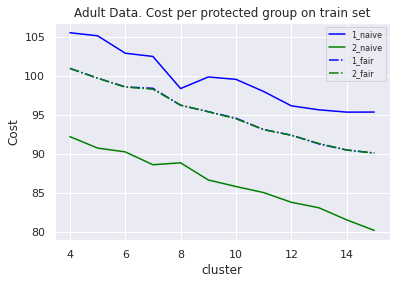

In [ ]:
plot_dynamics(old_adult_kmeans, 'cluster', 'Adult Data. Cost per protected group on')

In [ ]:
for k in old_adult_kmeans['fair'].keys():
    adult_kmeans['fair'][k]['train'][1] = adult_kmeans['fair'][k]['test'][1] = min(old_adult_kmeans['fair'][k]['train'][1], adult_kmeans['fair'][k]['train'][1])
    adult_kmeans['fair'][k]['train'][2] = adult_kmeans['fair'][k]['test'][2] = min(old_adult_kmeans['fair'][k]['train'][2], adult_kmeans['fair'][k]['train'][2])

In [ ]:
for k in old_adult_kmeans['naive'].keys():
    adult_kmeans['naive'][k]['train'][1] = adult_kmeans['naive'][k]['test'][1] = max(old_adult_kmeans['naive'][k]['train'][1], adult_kmeans['naive'][k]['train'][1])
    adult_kmeans['naive'][k]['train'][2] = adult_kmeans['naive'][k]['test'][2] = min(old_adult_kmeans['naive'][k]['train'][2], adult_kmeans['naive'][k]['train'][2])

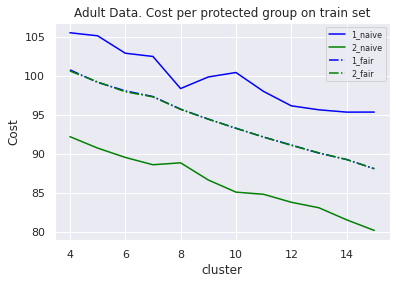

In [ ]:
plot_dynamics(adult_kmeans, 'cluster', 'Adult Data. Cost per protected group on')

In [ ]:
pca_param_dict = {'alpha':1e4, 'eta':3e-4, 'gamma':0, 'weighting':'uniform', 'max_iter':300, 'tol':1e-6, 'verbose':False, 'test_size':0., 'seed':43}

In [ ]:
lfw_PCA = compare_to_exist(pd.DataFrame(data_new), pd.Series(protected_feature), 'PCA', pca_param_dict)

In [ ]:
file_tag = 'lfw_pca.pickle'
with open('/content/drive/MyDrive/FairML/result_benchmark/{}'.format(file_tag), 'wb') as handle:
    pickle.dump(lfw_PCA, handle)

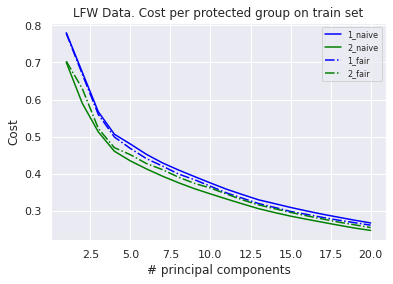

In [ ]:
bb = plot_dynamics(lfw_PCA, '# principal components', 'LFW Data. Cost per protected group on')

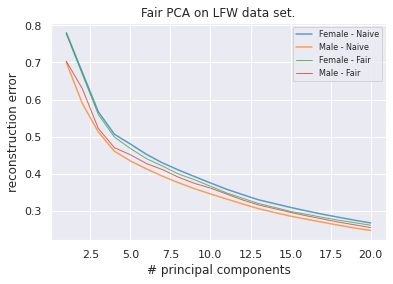

In [ ]:
plt.plot(bb['1_naive'], color=COLOURS[0], alpha=0.7, linewidth=1.5)
plt.plot(bb['2_naive'], color=COLOURS[1], alpha=0.7, linewidth=1.5)
plt.plot(bb['1_fair'], color=COLOURS[2], alpha=0.7, linewidth=1)
plt.plot(bb['2_fair'], color=COLOURS[3], alpha=0.7, linewidth=1)
plt.xlabel('# principal components')
plt.ylabel('reconstruction error')
plt.title('Fair PCA on LFW data set.')
plt.legend(['Female - Naive', 'Male - Naive', 'Female - Fair', 'Male - Fair'], loc='best', prop={'size': 8})
plt.show()

In [ ]:
def adjusting_fair_results(results_dict, scaler):
    
    for k, v in results_dict['fair'].items():
        for k1, v1 in v.items():
            for k2, v2 in v1.items():
                v1[k2] = v2 / scaler
    
    return results_dict

def get_dynamics(dataset_name, method, params):
    
    all_results = {}
    all_results['supervised'] = {}
    all_results['naive'] = {}
    all_results['fair'] = {}
    max_rank = 2
    for rank in range(4, 16):

        if rank <= max_rank:
            supervised_obj = Supervised_UL(rank=rank, dataset_name=dataset_name, method=method)
            all_results['supervised'][rank] = supervised_obj.score()
            all_results['naive'][rank] = supervised_obj.score_non_supervised()
            max_rank = supervised_obj._data_non_pred.shape[1]
        else:
            all_results['supervised'][rank] = all_results['supervised'][rank-1]
            supervised_obj.rank = rank
            all_results['naive'][rank] = supervised_obj.score_non_supervised()

        if method == 'PCA':
            all_results['fair'][rank] = {}
            fair_obj = FairPCA(rank=rank, **params)
            all_results['fair'][rank]['test'] = fair_obj.score(supervised_obj._data_non_super, supervised_obj._data[supervised_obj._protected])
            all_results['fair'][rank]['train'] = fair_obj.train_scores
        
        elif method == 'KMeans':
            
            fair_obj = FairKMeans(n_clusters=rank, **params)
            all_results['fair'][rank] = fair_obj.score(supervised_obj._data_non_super, supervised_obj._data[supervised_obj._protected])

        else:
            raise ValueError('Method is not recognized {}'.format(method))
    
    if method == 'KMeans':
        pass
        #scaler = supervised_obj._data_non_super.shape[1] / supervised_obj._data_non_pred.shape[1]
        #all_results = adjusting_fair_results(all_results, scaler)

    return all_results

In [ ]:
def plot_dynamics(results, xlabel, title):

    #train_super = {k:v['train'] for k, v in results['supervised'].items()}
    #test_super = {k:v['test'] for k, v in results['supervised'].items()}
    train_nonsuper = {k:v['train'] for k, v in results['naive'].items()}
    test_nonsuper = {k:v['test'] for k, v in results['naive'].items()}
    train_fair = {k:v['train'] for k, v in results['fair'].items()}
    test_fair = {k:v['test'] for k, v in results['fair'].items()}

    #train_s_df = pd.DataFrame(train_super).T
    train_ns_df =  pd.DataFrame(train_nonsuper).T
    train_fair_df = pd.DataFrame(train_fair).T
    ns_cols = [x for x in train_ns_df.columns if x != 'loss']
    fair_cols = [x for x in train_fair_df.columns if x != 'loss']
    train_ns_df = train_ns_df[ns_cols]
    train_fair_df = train_fair_df[fair_cols]
    
    groups = sorted(list([str(x) for x in train_ns_df.columns]))
    colors = ['blue', 'green', 'red', 'cyan', 'magenta']
    group_col = {g:c for g, c in zip(groups, colors)}

    methods = ['naive', 'supervised', 'fair']
    linestyles = ['-', '--', '-.']
    result_styles = {m:l for m, l in zip(methods, linestyles) }


    train_df = pd.concat([train_ns_df, train_fair_df], axis=1)
    train_df.columns = [str(x) + '_naive' for x in train_ns_df.columns] + \
      [str(x) + '_fair' for x in train_fair_df.columns]
      #[str(x) + '_supervised' for x in train_s_df.columns] 
  
    for col in train_df.columns:     
        g, m = col.split('_')
        plt.plot(train_df[col], linestyle=result_styles[m], color=group_col[g])
        
    plt.ylabel('Cost')
    plt.xlabel(xlabel)
    plt.title(title + ' train set')
    plt.legend(list(train_df.columns), loc='best', prop={'size': 8})
    plt.show()

    #test_s_df = pd.DataFrame(test_super).T
    test_ns_df =  pd.DataFrame(test_nonsuper).T
    test_fair_df = pd.DataFrame(test_fair).T
    test_df = pd.concat([test_ns_df, test_fair_df], axis=1)
    test_df.columns = [str(x) + '_naive' for x in test_ns_df.columns] + \
       [str(x) + '_fair' for x in test_fair_df.columns]
       #[str(x) + '_supervised' for x in test_s_df.columns] 

    #for col in test_df.columns: 
    #    g, m = col.split('_')
    #    plt.plot(test_df[col], linestyle=result_styles[m], color=group_col[g])
        
    #plt.ylabel('Cost')
    #plt.xlabel(xlabel)
    #plt.title(title + ' test set')
    #plt.legend(list(test_df.columns), loc='best', prop={'size': 8})
    #plt.show()
    return train_df

In [ ]:
def logistic_loss(beta, X, y):

    N = X.shape[0]
    p = 1/(1+np.exp(-np.dot(X, beta)))
    return (1/N) * np.sum(-y*np.log(p) - (1-y)*np.log(1-p)) 


def supervised_logistic_fair(beta, X, y, protected, lamda):
    
    unique_vals = sorted(list(protected.unique()))
    group_losses = []
    for val in unique_vals:
        mask = (protected == val)
        group_losses.append(logistic_loss(beta, X[mask], y[mask]))
    
    return logistic_loss(beta, X, y) + lamda * (group_losses[0] - group_losses[1]) ** 2
  

def stats_vs_fairness(beta, obj, data='train'):
    
    if data=='train':
        mask = obj._train_idx
    else:
        mask = obj._test_idx

    X = obj._data_non_super.loc[mask]
    y = obj._target_numeric.loc[mask]
    protected = obj._data[obj._protected].loc[mask]

    unique_vals = sorted(list(protected.unique()))
    group_losses = []
    for val in unique_vals:
        mask = (protected == val)
        group_losses.append(logistic_loss(beta, X[mask], y[mask]))
    
    return logistic_loss(beta, X, y), np.abs(group_losses[0] - group_losses[1])


def runner(beta, obj, lamda, data='train'):
    
    if data=='train':
        mask = obj._train_idx
    else:
        mask = obj._test_idx

    X = obj._data_non_super.loc[mask]
    y = obj._target_numeric.loc[mask]
    protected = obj._data[obj._protected].loc[mask]

    return supervised_logistic_fair(beta, X, y, protected, lamda)


def optimization_step(dataset_name, downsample_ratio, lamdas, seed=42):
    
    # initialise datasets
    supervised_obj = Supervised_UL(rank=1, dataset_name=dataset_name, method='PCA', downsample_ratio=downsample_ratio, seed=seed)
    _ = supervised_obj.score()
    _ = supervised_obj.score_non_supervised()
    
    # initialise starting point
    rng = np.random.RandomState(seed=seed)
    beta = rng.randn(supervised_obj._data_non_super.shape[1]) / np.sqrt(supervised_obj._data_non_super.shape[1])
    
    fairness_dict = {}
    fairness_dict['train'] = {}
    fairness_dict['test'] = {}

    stats_dict = {}
    stats_dict['train'] = {}
    stats_dict['test'] = {}
    
    for lamda in lamdas:

        stats_dict['train'][lamda] = []
        stats_dict['test'][lamda] = []

        fairness_dict['train'][lamda] = []
        fairness_dict['test'][lamda] = []

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
        for train_index, test_index in skf.split(np.arange(supervised_obj.N), supervised_obj._data[supervised_obj._protected]):

            # overwrite train/test indices
            supervised_obj._train_idx = train_index
            supervised_obj._test_idx = test_index

            supervised_obj._scaler.fit(supervised_obj._data_prep.loc[train_index])
            supervised_obj._scaled_data_prep = pd.DataFrame(data=supervised_obj._scaler.transform(supervised_obj._data_prep), columns=supervised_obj._data_prep.columns)

            supervised_obj._data_non_super = supervised_obj._scaled_data_prep.copy()
            for feat in [supervised_obj._target, supervised_obj._protected]:
                feat_cols = [x for x in supervised_obj._data_prep.columns if x.startswith(feat)]
                supervised_obj._data_non_super.drop(columns=feat_cols, axis=1, inplace=True)

            # run optimization
            res = minimize(runner, x0=beta, args=(supervised_obj, lamda, 'train'))

            # assess on train test
            S, F = stats_vs_fairness(res['x'], supervised_obj, data='train')
            stats_dict['train'][lamda].append(S)
            fairness_dict['train'][lamda].append(F)

            # assess on test test
            S, F = stats_vs_fairness(res['x'], supervised_obj, data='test')
            stats_dict['test'][lamda].append(S)
            fairness_dict['test'][lamda].append(F)

    return stats_dict, fairness_dict

In [ ]:
def optimization_with_downsampling(dataset_name, downsample_ratios, lamda, seed=42):
    
    fairness_dict = {}
    fairness_dict['train'] = {}
    fairness_dict['test'] = {}

    stats_dict = {}
    stats_dict['train'] = {}
    stats_dict['test'] = {}

    for downsample_ratio in downsample_ratios:
    
        # initialise datasets
        supervised_obj = Supervised_UL(rank=1, dataset_name=dataset_name, method='PCA', downsample_ratio=downsample_ratio, seed=seed)
        _ = supervised_obj.score()
        _ = supervised_obj.score_non_supervised()

        # initialise starting point
        rng = np.random.RandomState(seed=seed)
        beta = rng.randn(supervised_obj._data_non_super.shape[1]) / np.sqrt(supervised_obj._data_non_super.shape[1])

        stats_dict['train'][downsample_ratio] = []
        stats_dict['test'][downsample_ratio] = []

        fairness_dict['train'][downsample_ratio] = []
        fairness_dict['test'][downsample_ratio] = []

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
        for train_index, test_index in skf.split(np.arange(supervised_obj.N), supervised_obj._data[supervised_obj._protected]):

            # overwrite train/test indices
            supervised_obj._train_idx = train_index
            supervised_obj._test_idx = test_index
    
            supervised_obj._scaler.fit(supervised_obj._data_prep.loc[train_index])
            supervised_obj._scaled_data_prep = pd.DataFrame(data=supervised_obj._scaler.transform(supervised_obj._data_prep), columns=supervised_obj._data_prep.columns)

            supervised_obj._data_non_super = supervised_obj._scaled_data_prep.copy()
            for feat in [supervised_obj._target, supervised_obj._protected]:
                feat_cols = [x for x in supervised_obj._data_prep.columns if x.startswith(feat)]
                supervised_obj._data_non_super.drop(columns=feat_cols, axis=1, inplace=True)
      
            # run optimization
            res = minimize(runner, x0=beta, args=(supervised_obj, lamda, 'train'))

            # assess on train test
            S, F = stats_vs_fairness(res['x'], supervised_obj, data='train')
            stats_dict['train'][downsample_ratio].append(S)
            fairness_dict['train'][downsample_ratio].append(F)

            # assess on test test
            S, F = stats_vs_fairness(res['x'], supervised_obj, data='test')
            stats_dict['test'][downsample_ratio].append(S)
            fairness_dict['test'][downsample_ratio].append(F)

    return stats_dict, fairness_dict

In [ ]:
def elbow_plot(dataset_name, method):
    
    supervised_obj = Supervised_UL(rank=1, dataset_name=dataset_name, method=method)
    _ = supervised_obj.score()
    _ = supervised_obj.score_non_supervised()
    max_rank = supervised_obj._data_non_super.shape[1]
    train_data = supervised_obj._data_non_super.loc[supervised_obj._train_idx]
    results = []

    for rank in range(1, 21):

        if method == 'PCA':
            obj = PCA(n_components=max_rank)
            obj.fit(train_data)
            return obj.explained_variance_ratio_
            
        elif method == 'KMeans':
            obj = KMeans(n_clusters=rank)
            obj.fit(train_data)
            results.append(obj.inertia_)
        
        else:
            raise ValueError("don't recognize the method {}".format(method))

    return np.array(results)

In [ ]:
FIXED_PARAMETERS = {'PCA': {'loan_defaults': 3, 'adult': 8, 'german_credit': 5}, 'KMeans': {'loan_defaults': 3, 'adult': 9, 'german_credit': 3}}
#FIXED_PARAMETERS = {'PCA': {'loan_defaults': 1, 'adult': 1, 'german_credit': 1}, 'KMeans': {'loan_defaults': 3, 'adult': 9, 'german_credit': 3}}

In [ ]:
ALPHA_GRID = [1e-8, 1e-3, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]
SEEDS = [1,2,3,4,5,6,7]#[42, 77]#[43, 19, 271, 995, 666]

In [ ]:
def get_confint(dataset_name, method, params):
    
    all_results = {}
    all_results['supervised'] = {}
    all_results['naive'] = {}
    all_results['fair'] = {}
    rank = FIXED_PARAMETERS[method][dataset_name]

    for seed in SEEDS:

        supervised_obj = Supervised_UL(rank=rank, dataset_name=dataset_name, method=method, seed=seed)
        all_results['supervised'][seed] = supervised_obj.score()
        all_results['naive'][seed] = supervised_obj.score_non_supervised()
        all_results['fair'][seed] = {}

        for alpha in ALPHA_GRID:
            params['alpha'] = alpha

            if method == 'PCA':
                all_results['fair'][seed][alpha] = {}
                fair_obj = FairPCA(rank=rank, seed=seed, **params)
                all_results['fair'][seed][alpha]['test'] = fair_obj.score(supervised_obj._data_non_super, supervised_obj._data[supervised_obj._protected])
                all_results['fair'][seed][alpha]['train'] = fair_obj.train_scores
            
            elif method == 'KMeans':
                
                fair_obj = FairKMeans(n_clusters=rank, seed=seed, **params)
                all_results['fair'][seed][alpha] = fair_obj.score(supervised_obj._data_non_super, supervised_obj._data[supervised_obj._protected])

            else:
                raise ValueError('Method is not recognized {}'.format(method))
    
    file_tag = dataset_name + '_' + method + '_seeds_alphas_upd.pickle'
    with open('/content/drive/MyDrive/FairML/results2/{}'.format(file_tag), 'wb') as handle:
        pickle.dump(all_results, handle)

    return all_results

In [ ]:
def df_construct(results_dict, key):


    if key in ['naive', 'supervised']:
        df = pd.DataFrame(columns=['seed', 'train/test', 'attr', 'value'])
        i = 0

        for seed, v2 in results_dict[key].items():
            
            for part, v3 in v2.items():
                
                for attr, val in v3.items():
                    
                    df.loc[i, :] = [seed, part, attr, val]
                    i += 1
    else:
        df = pd.DataFrame(columns=['seed', 'alpha', 'train/test', 'attr', 'value'])
        i = 0

        for seed, v2 in results_dict[key].items():
            
            for alpha, v3 in v2.items():
                
                for part, v4 in v3.items():

                    for attr, val in v4.items():
                        
                        df.loc[i, :] = [seed, alpha, part, attr, val]
                        i += 1

    df['value'] = df['value'].astype(float) 
    return df


In [ ]:
def naive_vs_fair():

    datasets = ['german_credit', 'loan_defaults', 'adult']
    methods = ['PCA', 'KMeans']
    i = 0
    comparison_df = pd.DataFrame(columns=['dataset_name', 'naive_stat', 'fair_stat', 'naive_disparity', 'fair_disparity'])

    for dataset_name in datasets:
        for method in methods:
            if method == 'PCA':
                suffix = 'alphas_PC1'
            else:
                suffix = 'alphas'

            file_tag = dataset_name + '_' + method + '_seeds_{}.pickle'.format(suffix)  
            with open('/content/drive/MyDrive/FairML/results2/{}'.format(file_tag), 'rb') as handle:
                my_dict = pickle.load(handle)
            
            aa = df_construct(my_dict, 'naive')
            cc = df_construct(my_dict, 'fair')
            mask = (aa['attr'] == 'loss') & (aa['train/test']=='train')
            mask2 = (~aa['attr'].isin(['loss', 'analytical'])) & (aa['train/test']=='train')
            comparison_df.at[i, 'dataset_name'] = dataset_name
            comparison_df.at[i, 'naive_stat'] = aa[mask]['value'].mean()
            comparison_df.at[i, 'naive_disparity'] = np.mean(np.abs(aa[mask2].groupby('attr')['value'].mean().diff()))
            
            mask = (cc['attr'] == 'loss') & (cc['train/test']=='train') & (cc['alpha'] == cc['alpha'].min())
            mask2 = (~cc['attr'].isin(['loss', 'analytical'])) & (cc['train/test']=='train') & (cc['alpha'] == cc['alpha'].min())
            comparison_df.at[i, 'fair_stat'] = cc[mask]['value'].mean()
            comparison_df.at[i, 'fair_disparity'] = np.mean(np.abs(cc[mask2].groupby('attr')['value'].mean().diff()))
            i += 1
    
    return comparison_df

In [ ]:
comp_df = naive_vs_fair()

In [ ]:
comp_df['stat_diff'] = comp_df['fair_stat'] / comp_df['naive_stat']
comp_df['disparity_diff'] = comp_df['fair_disparity'] / comp_df['naive_disparity']

In [ ]:
comp_df.to_csv(r'/content/drive/MyDrive/FairML/comp_df.csv', index=False)

In [ ]:
dataset_name = 'german_credit'
method = 'KMeans'

file_tag = dataset_name + '_' + method + '_seeds_alphas.pickle'
with open('/content/drive/MyDrive/FairML/results2/{}'.format(file_tag), 'rb') as handle:
    my_dict = pickle.load(handle)

aa = df_construct(my_dict, 'naive')
bb = df_construct(my_dict, 'supervised')
cc = df_construct(my_dict, 'fair')

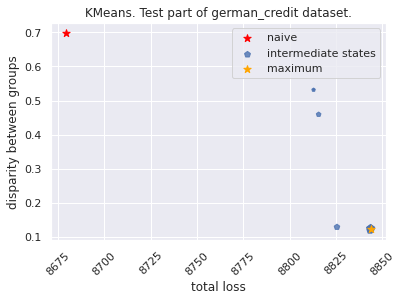

In [ ]:
TAG = 'test'

mask = (aa['attr'] == 'loss') & (aa['train/test']==TAG)
mask2 = (~aa['attr'].isin(['loss', 'analytical'])) & (aa['train/test']==TAG)
plt.scatter(aa[mask]['value'].mean(), np.mean(np.abs(aa[mask2].groupby('attr')['value'].mean().diff())), marker='*', color='red', s=60)

mask = (cc['attr'] == 'loss') & (cc['train/test']==TAG)
mask2 = (~cc['attr'].isin(['loss', 'analytical'])) & (cc['train/test']==TAG)


#sigma_approx = cc[mask2].groupby(['alpha', 'attr'])['value'].std().reset_index().groupby('alpha')['value'].mean() / np.sqrt(5)
x=cc[mask].groupby('alpha')['value'].mean()
y=np.abs(cc[mask2].groupby(['alpha', 'attr'])['value'].mean().diff()[1::2])
plt.scatter(x, y, s=4+10*np.argsort(ALPHA_GRID), alpha=0.8, marker='p')

mask = (cc['attr'] == 'loss') & (cc['train/test']==TAG) & (cc['alpha'] == cc['alpha'].max())
mask2 = (~cc['attr'].isin(['loss', 'analytical'])) & (cc['train/test']==TAG) & (cc['alpha'] == cc['alpha'].max())

plt.scatter(cc[mask]['value'].mean(), np.mean(np.abs(cc[mask2].groupby('attr')['value'].mean().diff())),  marker='*', color='orange', s=60)

#plt.errorbar(x, y,
#             xerr=cc[mask].groupby('alpha')['value'].std()/np.sqrt(5))
#             yerr=sigma_approx, fmt='o')
plt.xlabel('total loss')
plt.ylabel('disparity between groups')
plt.xticks(rotation=45)
plt.legend(['naive', 'intermediate states', 'maximum'], loc='best')
plt.title("{}. {} part of {} dataset.".format(method, TAG.capitalize(), dataset_name))
plt.show()

In [ ]:
mask = (cc['attr'] == 'loss') & (cc['train/test']=='train') & (cc['alpha'] == cc['alpha'].max())
mask2 = (~cc['attr'].isin(['loss', 'analytical'])) & (cc['train/test']=='train') & (cc['alpha'] == cc['alpha'].max())

In [ ]:
cc[mask]

,seed,alpha,train/test,attr,value
43,43,10000,train,loss,367296.542814
91,19,10000,train,loss,367842.457782
139,271,10000,train,loss,367246.495966
187,995,10000,train,loss,366942.862609
235,666,10000,train,loss,367361.993250


In [ ]:

plt.scatter(cc[mask]['value'].mean(), np.mean(np.abs(cc[mask2].groupby('attr')['value'].mean().diff())),  marker='*', color='orange', s=60)

In [ ]:
cc[(cc['train/test'] == 'test') & (cc['alpha'] == 1e3)]

,seed,alpha,train/test,attr,value
39,43,1000,test,1,16.047670
40,43,1000,test,loss,84171.510065
41,43,1000,test,2,12.702968
87,19,1000,test,1,14.673130
88,19,1000,test,loss,94159.812376
89,19,1000,test,2,16.363090
135,271,1000,test,1,16.616260
136,271,1000,test,loss,97552.609825
137,271,1000,test,2,16.024060
183,995,1000,test,1,15.683785


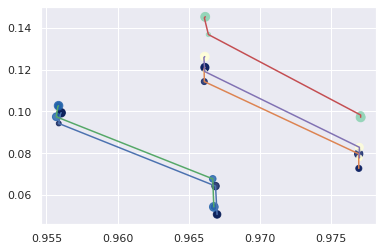

In [ ]:
plt.scatter(cc[mask]['value'], np.abs(cc[mask2]['value'].diff()[1::2]), s=4+2*np.argsort(cc[mask]['alpha']), c=cc[mask]['seed'], alpha=0.8, cmap='YlGnBu_r')
plt.plot(cc[mask].groupby(['alpha', 'seed'])['value'].mean().unstack('seed'), np.abs(cc[mask2].groupby(['alpha', 'seed', 'attr'])['value'].mean().diff()[1::2].unstack('seed').values))

In [ ]:
pca_param_dict = {'eta':1e-2, 'gamma':0, 'weighting':'empirical', 'max_iter':800, 'tol':1e-7, 'verbose':False}
german_PCA = get_confint(dataset_name='german_credit', method='PCA', params=pca_param_dict)

In [ ]:
kmeans_param_dict = {'n_init':10, 'eta':1e-1, 'weighting':'empirical', 'max_iter':500, 'tol':1e-7, 'verbose':False}
german_kmeans = get_confint(dataset_name='german_credit', method='KMeans', params=kmeans_param_dict)

In [ ]:
pca_param_dict = {'eta':1e-3, 'gamma':0, 'weighting':'empirical', 'max_iter':800, 'tol':1e-7, 'verbose':False}
loans_PCA = get_confint(dataset_name='loan_defaults', method='PCA', params=pca_param_dict)

In [ ]:
kmeans_param_dict = {'n_init':10, 'eta':1e-1, 'weighting':'empirical', 'max_iter':500, 'tol':1e-7, 'verbose':False}
loans_kmeans = get_confint(dataset_name='loan_defaults', method='KMeans', params=kmeans_param_dict)

In [ ]:
pca_param_dict = {'eta':1e-3, 'gamma':0, 'weighting':'empirical', 'max_iter':800, 'tol':1e-7, 'verbose':False}
adults_PCA = get_confint(dataset_name='adult', method='PCA', params=pca_param_dict)

In [ ]:
kmeans_param_dict = {'n_init':10, 'eta':1e-1, 'weighting':'empirical', 'max_iter':500, 'tol':1e-7, 'verbose':False}
adults_kmeans = get_confint(dataset_name='adult', method='KMeans', params=kmeans_param_dict)

## Selecting number of components

In [ ]:
dataset_name = 'german_credit'
method = 'PCA'
aa = elbow_plot(dataset_name=dataset_name, method=method)

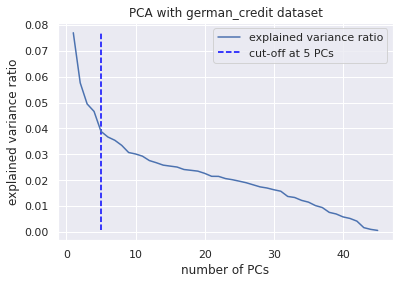

In [ ]:
plt.plot(np.arange(1, len(aa)+1), aa)
plt.vlines(5, min(aa), max(aa), colors='blue', linestyles='--')
plt.legend(['explained variance ratio', 'cut-off at 5 PCs'])
plt.title('{} with {} dataset'.format(method, dataset_name))
plt.xlabel('number of PCs')
plt.ylabel('explained variance ratio')
plt.savefig('/content/drive/MyDrive/FairML/pics/{} with {} dataset.png'.format(method, dataset_name))
plt.show()

In [ ]:
dataset_name = 'german_credit'
method = 'KMeans'
aa = elbow_plot(dataset_name=dataset_name, method=method)

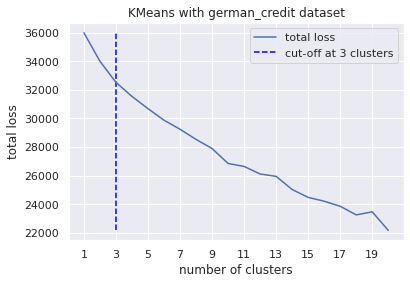

In [ ]:
plt.plot(np.arange(1, 21), aa)
plt.xticks(np.arange(1, 21, 2))
plt.vlines(3, min(aa), max(aa), colors='blue', linestyles='--')
plt.legend(['total loss', 'cut-off at 3 clusters'])
plt.title('{} with {} dataset'.format(method, dataset_name))
plt.xlabel('number of clusters')
plt.ylabel('total loss')
plt.savefig('/content/drive/MyDrive/FairML/pics/{} with {} dataset.png'.format(method, dataset_name))
plt.show()

In [ ]:
dataset_name = 'loan_defaults'
method = 'PCA'
aa = elbow_plot(dataset_name=dataset_name, method=method)

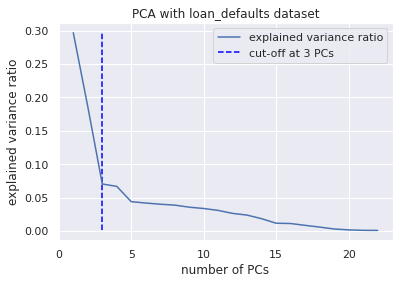

In [ ]:
plt.plot(np.arange(1, len(aa)+1), aa)
plt.vlines(3, min(aa), max(aa), colors='blue', linestyles='--')
plt.legend(['explained variance ratio', 'cut-off at 3 PCs'])
plt.title('{} with {} dataset'.format(method, dataset_name))
plt.xlabel('number of PCs')
plt.ylabel('explained variance ratio')
plt.savefig('/content/drive/MyDrive/FairML/pics/{} with {} dataset.png'.format(method, dataset_name))
plt.show()

In [ ]:
dataset_name = 'loan_defaults'
method = 'KMeans'
aa = elbow_plot(dataset_name=dataset_name, method=method)

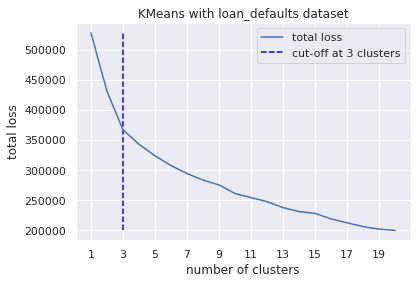

In [ ]:
plt.plot(np.arange(1, 21), aa)
plt.xticks(np.arange(1, 21, 2))
plt.vlines(3, min(aa), max(aa), colors='blue', linestyles='--')
plt.legend(['total loss', 'cut-off at 3 clusters'])
plt.title('{} with {} dataset'.format(method, dataset_name))
plt.xlabel('number of clusters')
plt.ylabel('total loss')
plt.savefig('/content/drive/MyDrive/FairML/pics/{} with {} dataset.png'.format(method, dataset_name))
plt.show()

In [ ]:
dataset_name = 'adult'
method = 'PCA'
aa = elbow_plot(dataset_name=dataset_name, method=method)

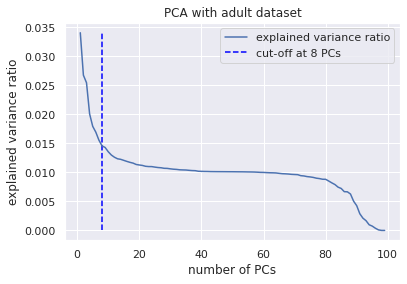

In [ ]:
plt.plot(np.arange(1, len(aa)+1), aa)
plt.vlines(8, min(aa), max(aa), colors='blue', linestyles='--')
plt.legend(['explained variance ratio', 'cut-off at 8 PCs'])
plt.title('{} with {} dataset'.format(method, dataset_name))
plt.xlabel('number of PCs')
plt.ylabel('explained variance ratio')
plt.savefig('/content/drive/MyDrive/FairML/pics/{} with {} dataset.png'.format(method, dataset_name))
plt.show()

In [ ]:
dataset_name = 'german_credit'
method = 'KMeans'
aa = elbow_plot(dataset_name=dataset_name, method=method)

KeyboardInterrupt: ignored

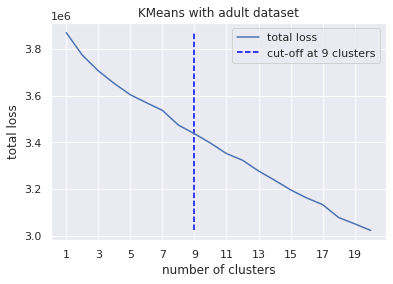

In [ ]:
plt.plot(np.arange(1, 21), aa)
plt.xticks(np.arange(1, 21, 2))
plt.vlines(9, min(aa), max(aa), colors='blue', linestyles='--')
plt.legend(['total loss', 'cut-off at 9 clusters'])
plt.title('{} with {} dataset'.format(method, dataset_name))
plt.xlabel('number of clusters')
plt.ylabel('total loss')
plt.savefig('/content/drive/MyDrive/FairML/pics/{} with {} dataset.png'.format(method, dataset_name))
plt.show()

## Test Suite 1

In [ ]:
pca_param_dict = {'alpha':1e-10, 'eta':5e-3, 'gamma':0, 'weighting':'empirical', 'max_iter':800, 'tol':1e-9, 'verbose':False}
german_PCA = get_dynamics(dataset_name='german_credit', method='PCA', params=pca_param_dict)

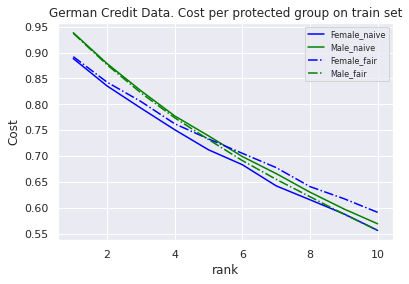

In [ ]:
plot_dynamics(german_PCA, 'rank', 'German Credit Data. Cost per protected group on')

In [ ]:
pca_param_dict = {'alpha':1e-10, 'eta':1e-3, 'gamma':0, 'weighting':'empirical', 'max_iter':500, 'tol':1e-7, 'verbose':False}
loans_PCA = get_dynamics(dataset_name='loan_defaults', method='PCA', params=pca_param_dict)

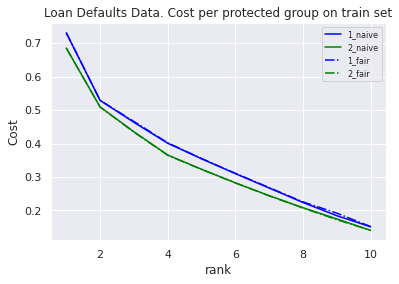

In [ ]:
plot_dynamics(loans_PCA, 'rank', 'Loan Defaults Data. Cost per protected group on')

In [ ]:
pca_param_dict = {'alpha':1e-10, 'eta':1e-3, 'gamma':0, 'weighting':'empirical', 'max_iter':700, 'tol':1e-7, 'verbose':False}
adult_PCA2 = get_dynamics(dataset_name='adult', method='PCA', params=pca_param_dict)

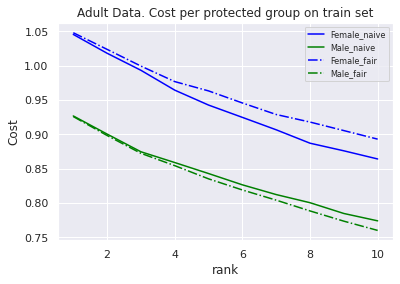

In [ ]:
plot_dynamics(adult_PCA, 'rank', 'Adult Data. Cost per protected group on')

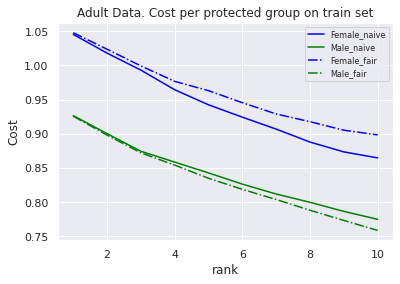

In [ ]:
plot_dynamics(adult_PCA2, 'rank', 'Adult Data. Cost per protected group on')

In [ ]:
kmeans_param_dict = {'n_init':10, 'alpha':1e-10, 'eta':1e-1, 'weighting':'empirical', 'max_iter':500, 'tol':1e-7, 'verbose':False}
adults_kmeans = get_dynamics(dataset_name='german_credit', method='KMeans', params=kmeans_param_dict)

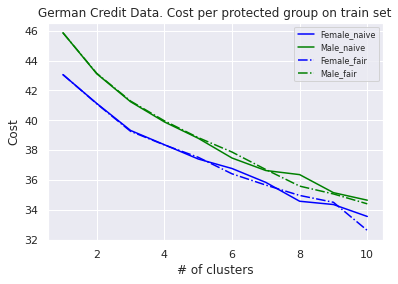

In [ ]:
plot_dynamics(adults_kmeans, '# of clusters', 'German Credit Data. Cost per protected group on')

In [ ]:
kmeans_param_dict = {'n_init':10, 'alpha':1e-10, 'eta':1e-1, 'weighting':'empirical', 'max_iter':500, 'tol':1e-7, 'verbose':False}
adults_kmeans = get_dynamics(dataset_name='loan_defaults', method='KMeans', params=kmeans_param_dict)

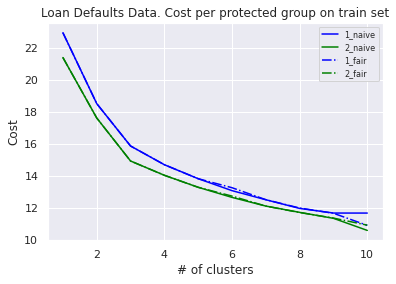

In [ ]:
plot_dynamics(adults_kmeans, '# of clusters', 'Loan Defaults Data. Cost per protected group on')

In [ ]:
kmeans_param_dict = {'n_init':10, 'alpha':1e-10, 'eta':1e-1, 'weighting':'empirical', 'max_iter':500, 'tol':1e-7, 'verbose':False}
adults_kmeans = get_dynamics(dataset_name='adult', method='KMeans', params=kmeans_param_dict)

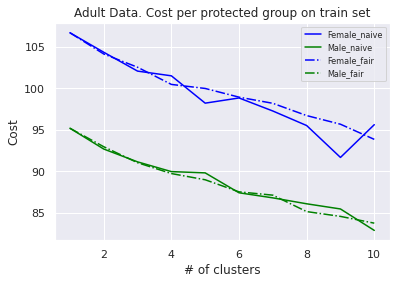

In [ ]:
plot_dynamics(adults_kmeans, '# of clusters', 'Adult Data. Cost per protected group on')

## Test Suite 2

In [ ]:
def plot_dynamics2(results, xlabel, title):

    train_super = {k:v['train'] for k, v in results['supervised'].items()}
    test_super = {k:v['test'] for k, v in results['supervised'].items()}
    train_nonsuper = {k:v['train'] for k, v in results['naive'].items()}
    test_nonsuper = {k:v['test'] for k, v in results['naive'].items()}
    train_fair = {k:v['train'] for k, v in results['fair'].items()}
    test_fair = {k:v['test'] for k, v in results['fair'].items()}

    train_s_df = pd.DataFrame(train_super).T
    train_ns_df =  pd.DataFrame(train_nonsuper).T
    train_fair_df = pd.DataFrame(train_fair).T
    
    
    groups = sorted(list([str(x) for x in train_ns_df.columns]))
    colors = ['blue', 'green', 'red', 'cyan', 'magenta']
    group_col = {g:c for g, c in zip(groups, colors)}

    methods = ['naive', 'fair', 'supervised']
    linestyles = ['-', '--', '-.']
    result_styles = {m:l for m, l in zip(methods, linestyles) }


    train_df = pd.concat([train_ns_df, train_fair_df, train_s_df], axis=1)
    train_df.columns = [str(x) + '_naive' for x in train_ns_df.columns] + \
       [str(x) + '_fair' for x in train_fair_df.columns] + \
      [str(x) + '_supervised' for x in train_s_df.columns]

    cols = train_df.columns
    for i in range(0, len(cols), 2):
        g, m = cols[i].split('_')
        plt.plot(2*(np.abs(train_df[cols[i]] -  train_df[cols[i+1]]))/(train_df[cols[i]] + train_df[cols[i+1]]), 'x', markersize=7)
        
    plt.ylabel('Cost')
    plt.xlabel(xlabel)
    plt.title(title + ' train set')
    plt.legend(methods, loc='best', prop={'size': 8})
    plt.show()

    test_s_df = pd.DataFrame(test_super).T
    test_ns_df =  pd.DataFrame(test_nonsuper).T
    test_fair_df = pd.DataFrame(test_fair).T
    test_df = pd.concat([test_ns_df, test_fair_df, test_s_df], axis=1)
    test_df.columns = [str(x) + '_naive' for x in test_ns_df.columns] + \
       [str(x) + '_fair' for x in test_fair_df.columns] +\
       [str(x) + '_supervised' for x in test_s_df.columns] 

    cols = train_df.columns
    for i in range(0, len(cols), 2): 
        g, m = cols[i].split('_')
        plt.plot(2*(np.abs(test_df[cols[i]] - test_df[cols[i+1]])) /(test_df[cols[i]] + test_df[cols[i+1]]) , 'x', markersize=7)
        
    plt.ylabel('Cost')
    plt.xlabel(xlabel)
    plt.title(title + ' test set')
    plt.legend(methods, loc='best', prop={'size': 8})
    plt.show()


In [ ]:
pca_param_dict = {'alpha':1e6, 'eta':1e-3, 'gamma':0, 'weighting':'uniform', 'max_iter':500, 'tol':1e-8, 'verbose':False}
german_PCA = get_dynamics(dataset_name='german_credit', method='PCA', params=pca_param_dict)

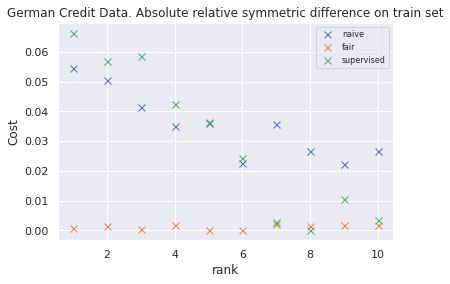

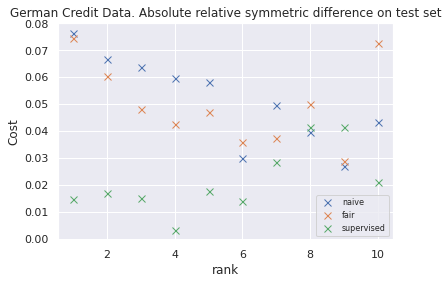

In [ ]:
plot_dynamics2(german_PCA, 'rank', 'German Credit Data. Absolute relative symmetric difference on')

In [ ]:
pca_param_dict = {'alpha':1e8, 'eta':1e-3, 'gamma':0, 'weighting':'uniform', 'max_iter':700, 'tol':1e-8, 'verbose':False}
german_loans = get_dynamics(dataset_name='loan_defaults', method='PCA', params=pca_param_dict)

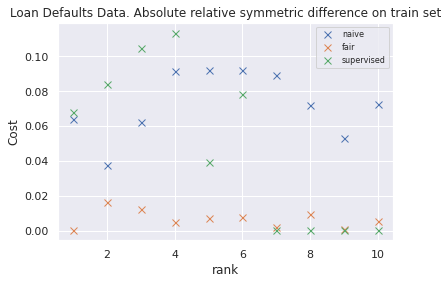

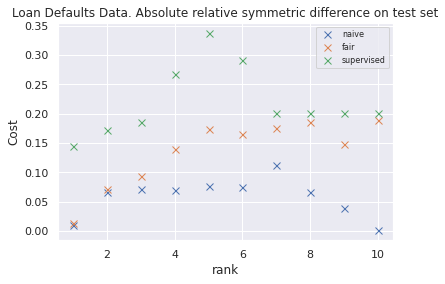

In [ ]:
plot_dynamics2(german_loans, 'rank', 'Loan Defaults Data. Absolute relative symmetric difference on')

In [ ]:
pca_param_dict = {'alpha':1e8, 'eta':1e-3, 'gamma':0, 'weighting':'uniform', 'max_iter':700, 'tol':1e-8, 'verbose':False}
adults_pca = get_dynamics(dataset_name='adult', method='PCA', params=pca_param_dict)

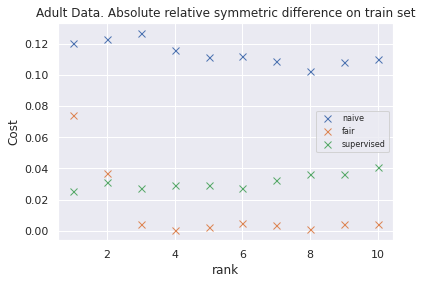

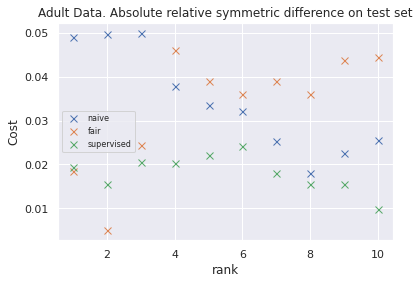

In [ ]:
plot_dynamics2(adults_pca, 'rank', 'Adult Data. Absolute relative symmetric difference on')

In [ ]:
kmeans_param_dict = {'n_init':10, 'alpha':1e8, 'eta':1e-1, 'weighting':'uniform', 'max_iter':700, 'tol':1e-7, 'verbose':False}
german_kmeans = get_dynamics(dataset_name='german_credit', method='KMeans', params=kmeans_param_dict)

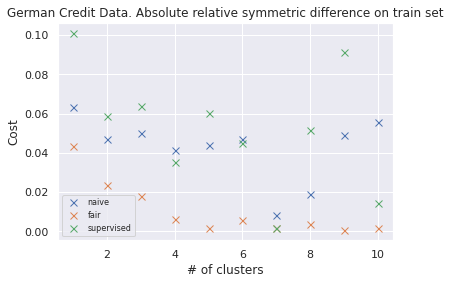

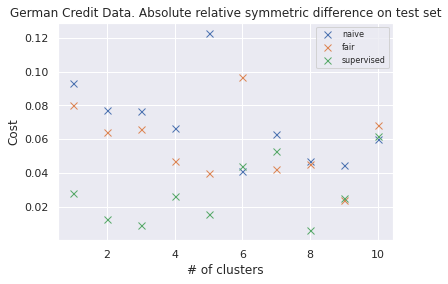

In [ ]:
plot_dynamics2(german_kmeans, '# of clusters', 'German Credit Data. Absolute relative symmetric difference on')

In [ ]:
kmeans_param_dict = {'n_init':10, 'alpha':1e8, 'eta':1e-2, 'weighting':'uniform', 'max_iter':700, 'tol':1e-7, 'verbose':False}
german_kmeans = get_dynamics(dataset_name='german_credit', method='KMeans', params=kmeans_param_dict)

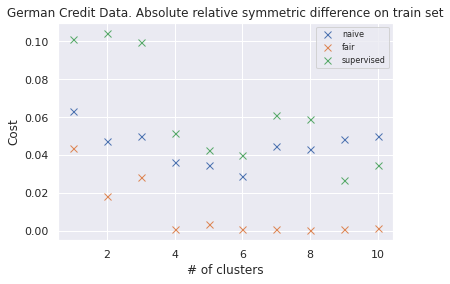

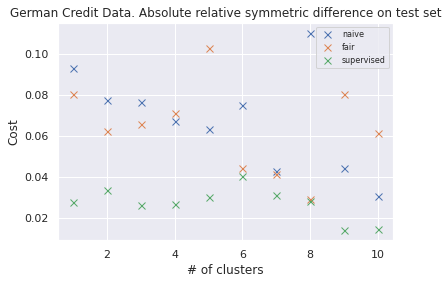

In [ ]:
plot_dynamics2(german_kmeans, '# of clusters', 'German Credit Data. Absolute relative symmetric difference on')

In [ ]:
kmeans_param_dict = {'n_init':10, 'alpha':1e8, 'eta':1e-2, 'weighting':'uniform', 'max_iter':700, 'tol':1e-7, 'verbose':False}
loans_kmeans = get_dynamics(dataset_name='loan_defaults', method='KMeans', params=kmeans_param_dict)

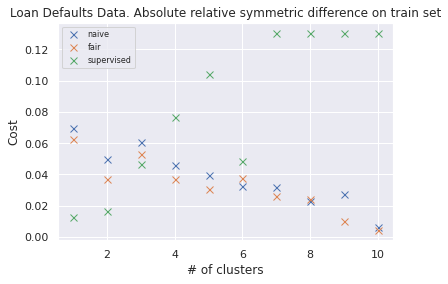

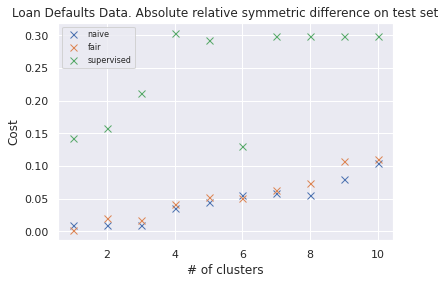

In [ ]:
plot_dynamics2(loans_kmeans, '# of clusters', 'Loan Defaults Data. Absolute relative symmetric difference on')

In [ ]:
kmeans_param_dict = {'n_init':10, 'alpha':1e8, 'eta':1e-1, 'weighting':'uniform', 'max_iter':700, 'tol':1e-7, 'verbose':False}
loans_kmeans = get_dynamics(dataset_name='loan_defaults', method='KMeans', params=kmeans_param_dict)

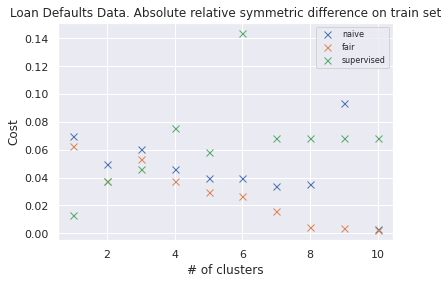

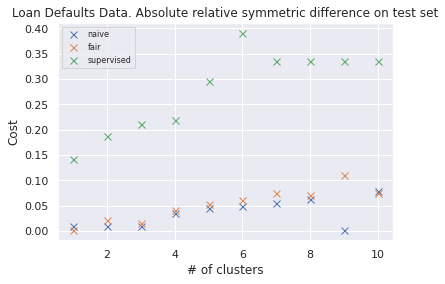

In [ ]:
plot_dynamics2(loans_kmeans, '# of clusters', 'Loan Defaults Data. Absolute relative symmetric difference on')

In [ ]:
kmeans_param_dict = {'n_init':10, 'alpha':1e8, 'eta':1e-2, 'weighting':'uniform', 'max_iter':700, 'tol':1e-7, 'verbose':False}
adult_kmeans = get_dynamics(dataset_name='adult', method='KMeans', params=kmeans_param_dict)

In [ ]:
plot_dynamics2(adult_kmeans, '# of clusters', 'Loan Defaults Data. Absolute relative symmetric difference on')

NameError: ignored

## Optimization with supervision

In [ ]:
def save_results(dataset_name, lamdas, seeds, downsample_ratio=None):
    
    results_stat = {}
    results_fair = {}
    for seed in seeds:
        stats_dct, fair_dct = optimization_step(dataset_name=dataset_name, downsample_ratio=downsample_ratio, lamdas=lamdas, seed=seed)
        results_stat[seed] = stats_dct
        results_fair[seed] = fair_dct
    
    file_tag = dataset_name + '_lambdas_' + str(downsample_ratio) + '_stat3.pickle'
    with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'wb') as handle:
        pickle.dump(results_stat, handle)
    
    file_tag = dataset_name + '_lambdas_' + str(downsample_ratio) + '_fair3.pickle'
    with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'wb') as handle:
        pickle.dump(results_fair, handle)

    return results_stat, results_fair

In [ ]:
def save_imbalance_results(dataset_name, downsample_ratios, seeds, lamda):
    
    results_stat = {}
    results_fair = {}
    for seed in seeds:
        stats_dct, fair_dct = optimization_with_downsampling(dataset_name=dataset_name, downsample_ratios=downsample_ratios, lamda=lamda, seed=seed)
        results_stat[seed] = stats_dct
        results_fair[seed] = fair_dct
    
    file_tag = dataset_name + '_downsamples_' + str(lamda) + '_stat3.pickle'
    with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'wb') as handle:
        pickle.dump(results_stat, handle)
    
    file_tag = dataset_name + '_downsamples_' + str(lamda) + '_fair3.pickle'
    with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'wb') as handle:
        pickle.dump(results_fair, handle)

    return results_stat, results_fair

In [ ]:
test_lamdas = [1e-2, 5e-2, 1e-1, 5e-1, 1, 5, 1e1, 5e1, 1e2, 5e2]
test_downsample_ratios = [20]#[None, 5, 10, 15, 20]
test_seeds = [42, 77, 271]#[43, 19, 995, 666]

In [ ]:
a, b = save_results(dataset_name='german_credit', lamdas=test_lamdas, seeds=test_seeds, downsample_ratio=None)

In [ ]:
c, d = save_results(dataset_name='german_credit', lamdas=test_lamdas, seeds=test_seeds, downsample_ratio=10)

In [ ]:
e, f = save_imbalance_results(dataset_name='german_credit', downsample_ratios=test_downsample_ratios, lamda=0.1, seeds=test_seeds)

In [ ]:
g, h = save_imbalance_results(dataset_name='german_credit', downsample_ratios=test_downsample_ratios, lamda=50, seeds=test_seeds)

In [ ]:
### merging two datasets

what = 'stat'
dataset_name = 'german_credit'

file_tag = '{}_lambdas_10_{}.pickle'.format(dataset_name, what)
with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'rb') as handle:
    a = pickle.load(handle)

file_tag = '{}_lambdas_10_{}2.pickle'.format(dataset_name, what)
with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'rb') as handle:
    a1 = pickle.load(handle)

a.update(a1)     

file_tag = '{}_lambdas_10_{}_all.pickle'.format(dataset_name, what)
with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'wb') as handle:
    pickle.dump(a, handle)

In [ ]:
e1[42]['train'][20] = e[42]['train'][20]
e1[42]['test'][20] = e[42]['test'][20]

g1[42]['train'][20] = g[42]['train'][20]
g1[42]['test'][20] = g[42]['test'][20]

In [ ]:
e1[77]['train'][20] = e[77]['train'][20]
e1[77]['test'][20] = e[77]['test'][20]

g1[77]['train'][20] = g[77]['train'][20]
g1[77]['test'][20] = g[77]['test'][20]

In [ ]:
e1[271]['train'][20] = e[271]['train'][20]
e1[271]['test'][20] = e[271]['test'][20]

g1[271]['train'][20] = g[271]['train'][20]
g1[271]['test'][20] = g[271]['test'][20]

In [ ]:
dataset_name = 'german_credit'
what = 'fair'

file_tag = '{}_downsamples_0.1_{}_all.pickle'.format(dataset_name, what)
with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'wb') as handle:
    pickle.dump(f1, handle)

In [ ]:
dataset_name = 'german_credit'

file_tag = '{}_lambdas_None_stat_all.pickle'.format(dataset_name)
with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'rb') as handle:
    a = pickle.load(handle)

file_tag = '{}_lambdas_None_fair_all.pickle'.format(dataset_name)
with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'rb') as handle:
    b = pickle.load(handle)

file_tag = '{}_lambdas_10_stat_all.pickle'.format(dataset_name)
with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'rb') as handle:
    c = pickle.load(handle)

file_tag = '{}_lambdas_10_fair_all.pickle'.format(dataset_name)
with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'rb') as handle:
    d = pickle.load(handle)

file_tag = '{}_downsamples_0.1_stat_all.pickle'.format(dataset_name)
with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'rb') as handle:
    e = pickle.load(handle)

file_tag = '{}_downsamples_0.1_fair_all.pickle'.format(dataset_name)
with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'rb') as handle:
    f = pickle.load(handle)

file_tag = '{}_downsamples_50_stat_all.pickle'.format(dataset_name)
with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'rb') as handle:
    g = pickle.load(handle)

file_tag = '{}_downsamples_50_fair_all.pickle'.format(dataset_name)
with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'rb') as handle:
    h = pickle.load(handle)

In [ ]:
#FOR ADULT ONLY

dataset_name = 'adult'

file_tag = '{}_lambdas_None_stat.pickle'.format(dataset_name)
with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'rb') as handle:
    a = pickle.load(handle)

file_tag = '{}_lambdas_None_fair.pickle'.format(dataset_name)
with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'rb') as handle:
    b = pickle.load(handle)

file_tag = '{}_lambdas_10_stat.pickle'.format(dataset_name)
with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'rb') as handle:
    c = pickle.load(handle)

file_tag = '{}_lambdas_10_fair.pickle'.format(dataset_name)
with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'rb') as handle:
    d = pickle.load(handle)

file_tag = '{}_downsamples_0.1_stat.pickle'.format(dataset_name)
with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'rb') as handle:
    e = pickle.load(handle)

file_tag = '{}_downsamples_0.1_fair.pickle'.format(dataset_name)
with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'rb') as handle:
    f = pickle.load(handle)

file_tag = '{}_downsamples_100.0_stat.pickle'.format(dataset_name)
with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'rb') as handle:
    g = pickle.load(handle)

file_tag = '{}_downsamples_100.0_fair.pickle'.format(dataset_name)
with open('/content/drive/MyDrive/FairML/results/{}'.format(file_tag), 'rb') as handle:
    h = pickle.load(handle)

In [ ]:
DEFAULT_IMBALANCE_PER_DATASET = {'loan_defaults':1.5235531628532974, 'german_credit': 2.225806451612903, 'adult':2.0164278656126484}

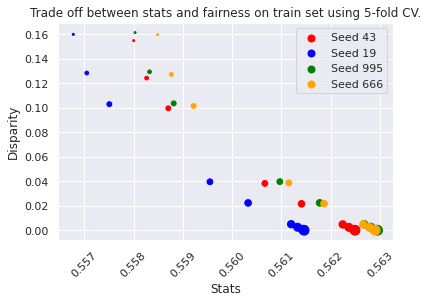

In [ ]:
plt.scatter(pd.Series({k: np.mean(v) for k, v in a[43]['train'].items()}).values, pd.Series({k: np.mean(v) for k, v in b[43]['train'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in b[43]['train'].items()}).index), color='red')
plt.scatter(pd.Series({k: np.mean(v) for k, v in a[19]['train'].items()}).values, pd.Series({k: np.mean(v) for k, v in b[19]['train'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in b[19]['train'].items()}).index), color='blue')
plt.scatter(pd.Series({k: np.mean(v) for k, v in a[995]['train'].items()}).values, pd.Series({k: np.mean(v) for k, v in b[995]['train'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in b[995]['train'].items()}).index), color='green')
plt.scatter(pd.Series({k: np.mean(v) for k, v in a[666]['train'].items()}).values, pd.Series({k: np.mean(v) for k, v in b[666]['train'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in b[666]['train'].items()}).index), color='orange')
plt.xlabel('Stats')
plt.xticks(rotation=45)
plt.ylabel('Disparity')
plt.legend(['Seed 43', 'Seed 19', 'Seed 995', 'Seed 666'])
plt.title('Trade off between stats and fairness on train set using 5-fold CV.')
plt.show()

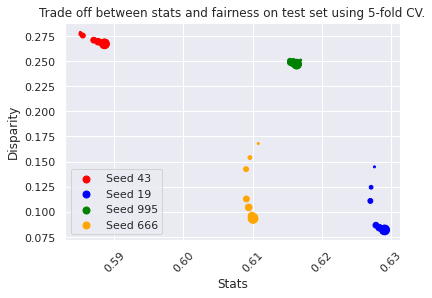

In [ ]:
plt.scatter(pd.Series({k: np.mean(v) for k, v in a[43]['test'].items()}).values, pd.Series({k: np.mean(v) for k, v in b[43]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in b[43]['test'].items()}).index), color='red')
plt.scatter(pd.Series({k: np.mean(v) for k, v in a[19]['test'].items()}).values, pd.Series({k: np.mean(v) for k, v in b[19]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in b[19]['test'].items()}).index), color='blue')
plt.scatter(pd.Series({k: np.mean(v) for k, v in a[995]['test'].items()}).values, pd.Series({k: np.mean(v) for k, v in b[995]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in b[995]['test'].items()}).index), color='green')
plt.scatter(pd.Series({k: np.mean(v) for k, v in a[666]['test'].items()}).values, pd.Series({k: np.mean(v) for k, v in b[666]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in b[666]['test'].items()}).index), color='orange')
plt.xlabel('Stats')
plt.xticks(rotation=45)
plt.ylabel('Disparity')
plt.legend(['Seed 43', 'Seed 19', 'Seed 995', 'Seed 666'], loc=3)
plt.title('Trade off between stats and fairness on test set using 5-fold CV.')
plt.show()

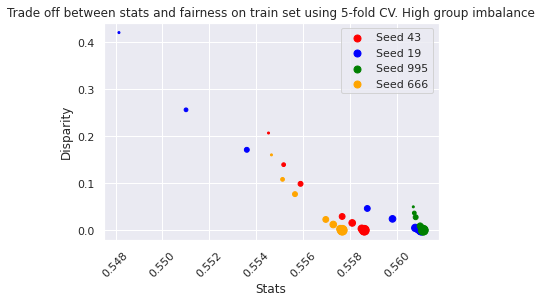

In [ ]:
plt.scatter(pd.Series({k: np.mean(v) for k, v in c[43]['train'].items()}).values, pd.Series({k: np.mean(v) for k, v in d[43]['train'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in d[43]['train'].items()}).index), color='red')
plt.scatter(pd.Series({k: np.mean(v) for k, v in c[19]['train'].items()}).values, pd.Series({k: np.mean(v) for k, v in d[19]['train'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in d[19]['train'].items()}).index), color='blue')
plt.scatter(pd.Series({k: np.mean(v) for k, v in c[995]['train'].items()}).values, pd.Series({k: np.mean(v) for k, v in d[995]['train'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in d[995]['train'].items()}).index), color='green')
plt.scatter(pd.Series({k: np.mean(v) for k, v in c[666]['train'].items()}).values, pd.Series({k: np.mean(v) for k, v in d[666]['train'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in d[666]['train'].items()}).index), color='orange')
plt.xlabel('Stats')
plt.xticks(rotation=45)
plt.ylabel('Disparity')
plt.legend(['Seed 43', 'Seed 19', 'Seed 995', 'Seed 666'])
plt.title('Trade off between stats and fairness on train set using 5-fold CV. High group imbalance')
plt.show()

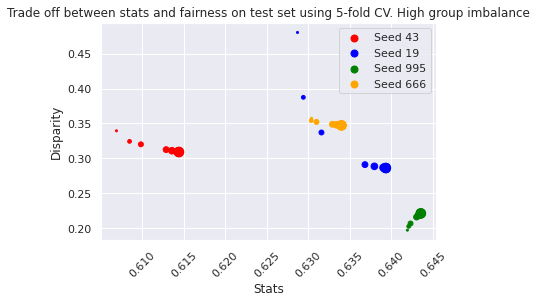

In [ ]:
plt.scatter(pd.Series({k: np.mean(v) for k, v in c[43]['test'].items()}).values, pd.Series({k: np.mean(v) for k, v in d[43]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in d[43]['test'].items()}).index), color='red')
plt.scatter(pd.Series({k: np.mean(v) for k, v in c[19]['test'].items()}).values, pd.Series({k: np.mean(v) for k, v in d[19]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in d[19]['test'].items()}).index), color='blue')
plt.scatter(pd.Series({k: np.mean(v) for k, v in c[995]['test'].items()}).values, pd.Series({k: np.mean(v) for k, v in d[995]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in d[995]['test'].items()}).index), color='green')
plt.scatter(pd.Series({k: np.mean(v) for k, v in c[666]['test'].items()}).values, pd.Series({k: np.mean(v) for k, v in d[666]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in d[666]['test'].items()}).index), color='orange')
plt.xlabel('Stats')
plt.xticks(rotation=45)
plt.ylabel('Disparity')
plt.legend(['Seed 43', 'Seed 19', 'Seed 995', 'Seed 666'])
plt.title('Trade off between stats and fairness on test set using 5-fold CV. High group imbalance')
plt.show()

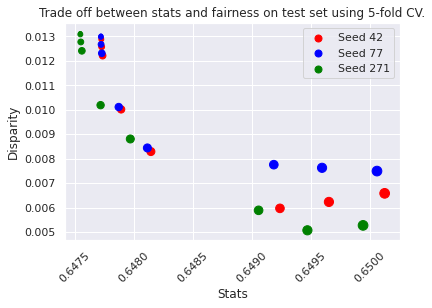

In [ ]:
plt.scatter(pd.Series({k: np.mean(v) for k, v in a[42]['test'].items()}).values, pd.Series({k: np.mean(v) for k, v in b[42]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in b[42]['test'].items()}).index), color='red')
plt.scatter(pd.Series({k: np.mean(v) for k, v in a[77]['test'].items()}).values, pd.Series({k: np.mean(v) for k, v in b[77]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in b[77]['test'].items()}).index), color='blue')
plt.scatter(pd.Series({k: np.mean(v) for k, v in a[271]['test'].items()}).values, pd.Series({k: np.mean(v) for k, v in b[271]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in b[271]['test'].items()}).index), color='green')
plt.xlabel('Stats')
plt.xticks(rotation=45)
plt.ylabel('Disparity')
plt.legend(['Seed 42', 'Seed 77', 'Seed 271'])
plt.title('Trade off between stats and fairness on test set using 5-fold CV.')
plt.show()

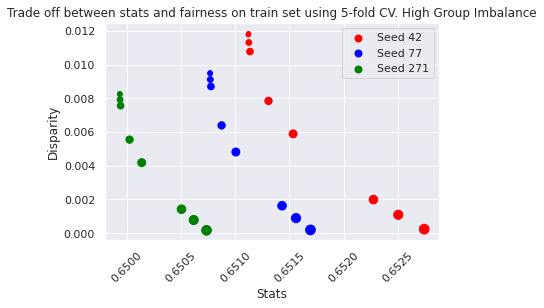

In [ ]:
plt.scatter(pd.Series({k: np.mean(v) for k, v in c[42]['train'].items()}).values, pd.Series({k: np.mean(v) for k, v in d[42]['train'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in d[42]['train'].items()}).index), color='red')
plt.scatter(pd.Series({k: np.mean(v) for k, v in c[77]['train'].items()}).values, pd.Series({k: np.mean(v) for k, v in d[77]['train'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in d[77]['train'].items()}).index), color='blue')
plt.scatter(pd.Series({k: np.mean(v) for k, v in c[271]['train'].items()}).values, pd.Series({k: np.mean(v) for k, v in d[271]['train'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in d[271]['train'].items()}).index), color='green')
plt.xlabel('Stats')
plt.xticks(rotation=45)
plt.ylabel('Disparity')
plt.legend(['Seed 42', 'Seed 77', 'Seed 271'])
plt.title('Trade off between stats and fairness on train set using 5-fold CV. High Group Imbalance')
plt.show()

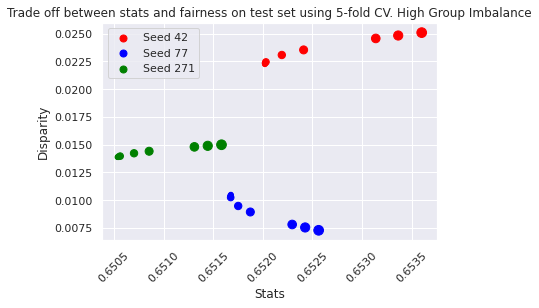

In [ ]:
plt.scatter(pd.Series({k: np.mean(v) for k, v in c[42]['test'].items()}).values, pd.Series({k: np.mean(v) for k, v in d[42]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in d[42]['test'].items()}).index), color='red')
plt.scatter(pd.Series({k: np.mean(v) for k, v in c[77]['test'].items()}).values, pd.Series({k: np.mean(v) for k, v in d[77]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in d[77]['test'].items()}).index), color='blue')
plt.scatter(pd.Series({k: np.mean(v) for k, v in c[271]['test'].items()}).values, pd.Series({k: np.mean(v) for k, v in d[271]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in d[271]['test'].items()}).index), color='green')
plt.xlabel('Stats')
plt.xticks(rotation=45)
plt.ylabel('Disparity')
plt.legend(['Seed 42', 'Seed 77', 'Seed 271'])
plt.title('Trade off between stats and fairness on test set using 5-fold CV. High Group Imbalance')
plt.show()

In [ ]:
pcz = pd.DataFrame(h[42]['test'])
#pcz.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
def results_together(dict_obj, dataset_name, isTrain=True):
    
    all_tbls = []
    linear_results = []
    sorted_seed = sorted(dict_obj.keys())


    for seed in sorted_seed:
        if isTrain:
            temp = pd.DataFrame(dict_obj[seed]['train'])
        else:
            temp = pd.DataFrame(dict_obj[seed]['test'])
        temp.columns = temp.columns.fillna(DEFAULT_IMBALANCE_PER_DATASET[dataset_name])
        temp.replace([np.inf, -np.inf], np.nan, inplace=True)
        temp = temp.fillna(temp.mean())

        lm_data = temp.mean()
        lm = LinearRegression()
        lm.fit(lm_data.index.values.reshape(-1, 1), lm_data.values)

        y_pred = lm.predict(lm_data.index.values.reshape(-1, 1))
        linear_results.append(y_pred)
        temp['seed'] = seed
        all_tbls.append(temp)


    all_temp = pd.concat(all_tbls)
    cols = [x for x in all_temp if x!= 'seed']
    lm_data = all_temp[cols].mean()
    lm = LinearRegression()
    lm.fit(lm_data.index.values.reshape(-1, 1), lm_data.values)
    y_pred = lm.predict(lm_data.index.values.reshape(-1, 1))
    linear_results.append(y_pred)

    return all_temp, linear_results

In [ ]:
aa, linear_aa = results_together(h, 'adult', False)

In [ ]:
COLOURS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',  '#e377c2']
FLATTEN_COLOURS = [x for i in range(5) for x in COLOURS[:3]]

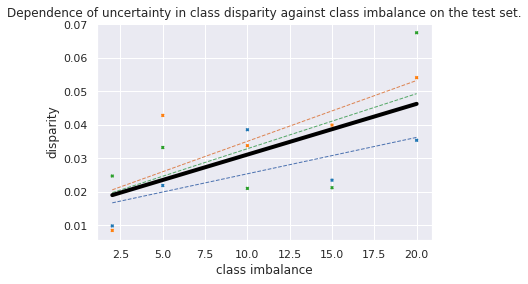

In [ ]:
plt.plot(aa.columns[:5].values, np.array(linear_aa[:-1]).T, '--', linewidth=1)
plt.plot(aa.columns[:5].values, np.array(linear_aa[-1]).T, linewidth=4, color='black')
indiv_points = aa.groupby('seed')[aa.columns[:-1]].mean()
plt.scatter(np.repeat(indiv_points.columns.values, 3), indiv_points.values.T, s=7, marker='x', color=FLATTEN_COLOURS)
plt.xlabel('class imbalance')
plt.ylabel('disparity')
plt.title('Dependence of uncertainty in class disparity against class imbalance on the test set.')
plt.show()

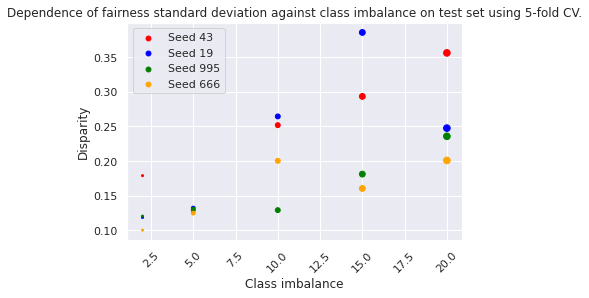

In [ ]:
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in f[43]['test'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in f[43]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in f[43]['test'].items()}).index.fillna(2)), color='red')
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in f[19]['test'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in f[19]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in f[19]['test'].items()}).index.fillna(2)), color='blue')
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in f[995]['test'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in f[995]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in f[995]['test'].items()}).index.fillna(2)), color='green')
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in f[666]['test'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in f[666]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in f[666]['test'].items()}).index.fillna(2)), color='orange')
plt.xlabel('Class imbalance')
plt.xticks(rotation=45)
plt.ylabel('Disparity')
plt.legend(['Seed 43', 'Seed 19', 'Seed 995', 'Seed 666'])
plt.title('Dependence of fairness standard deviation against class imbalance on test set using 5-fold CV.')
plt.show()

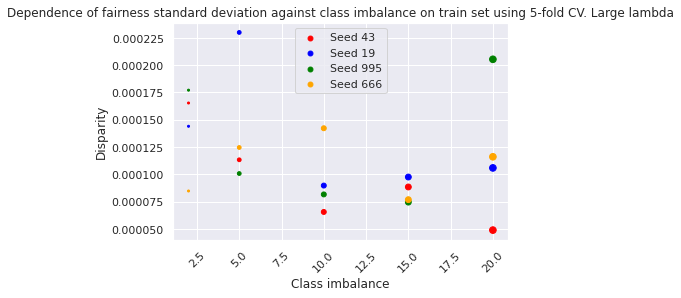

In [ ]:
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in h[43]['train'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in h[43]['train'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in h[43]['train'].items()}).index.fillna(2)), color='red')
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in h[19]['train'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in h[19]['train'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in h[19]['train'].items()}).index.fillna(2)), color='blue')
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in h[995]['train'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in h[995]['train'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in h[995]['train'].items()}).index.fillna(2)), color='green')
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in h[666]['train'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in h[666]['train'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in h[666]['train'].items()}).index.fillna(2)), color='orange')
plt.xlabel('Class imbalance')
plt.xticks(rotation=45)
plt.ylabel('Disparity')
plt.legend(['Seed 43', 'Seed 19', 'Seed 995', 'Seed 666'])
plt.title('Dependence of fairness standard deviation against class imbalance on train set using 5-fold CV. Large lambda')
plt.show()

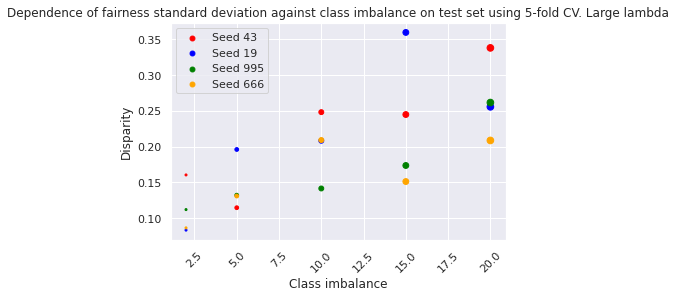

In [ ]:
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in h[43]['test'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in h[43]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in h[43]['test'].items()}).index.fillna(2)), color='red')
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in h[19]['test'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in h[19]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in h[19]['test'].items()}).index.fillna(2)), color='blue')
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in h[995]['test'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in h[995]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in h[995]['test'].items()}).index.fillna(2)), color='green')
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in h[666]['test'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in h[666]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in h[666]['test'].items()}).index.fillna(2)), color='orange')
plt.xlabel('Class imbalance')
plt.xticks(rotation=45)
plt.ylabel('Disparity')
plt.legend(['Seed 43', 'Seed 19', 'Seed 995', 'Seed 666'])
plt.title('Dependence of fairness standard deviation against class imbalance on test set using 5-fold CV. Large lambda')
plt.show()

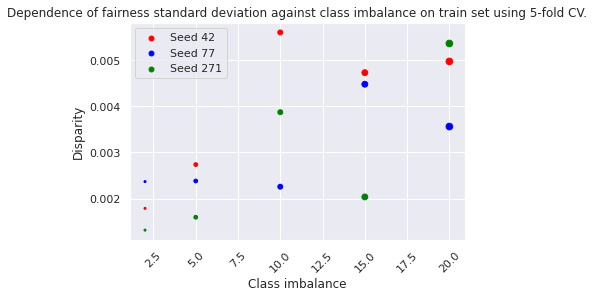

In [ ]:
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in f[42]['train'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in f[42]['train'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in f[42]['train'].items()}).index.fillna(2)), color='red')
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in f[77]['train'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in f[77]['train'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in f[77]['train'].items()}).index.fillna(2)), color='blue')
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in f[271]['train'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in f[271]['train'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in f[271]['train'].items()}).index.fillna(2)), color='green')
plt.xlabel('Class imbalance')
plt.xticks(rotation=45)
plt.ylabel('Disparity')
plt.legend(['Seed 42', 'Seed 77', 'Seed 271'])
plt.title('Dependence of fairness standard deviation against class imbalance on train set using 5-fold CV.')
plt.show()

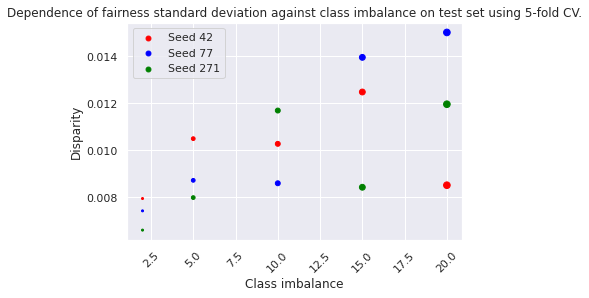

In [ ]:
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in f[42]['test'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in f[42]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in f[42]['test'].items()}).index.fillna(2)), color='red')
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in f[77]['test'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in f[77]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in f[77]['test'].items()}).index.fillna(2)), color='blue')
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in f[271]['test'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in f[271]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in f[271]['test'].items()}).index.fillna(2)), color='green')
plt.xlabel('Class imbalance')
plt.xticks(rotation=45)
plt.ylabel('Disparity')
plt.legend(['Seed 42', 'Seed 77', 'Seed 271'])
plt.title('Dependence of fairness standard deviation against class imbalance on test set using 5-fold CV.')
plt.show()

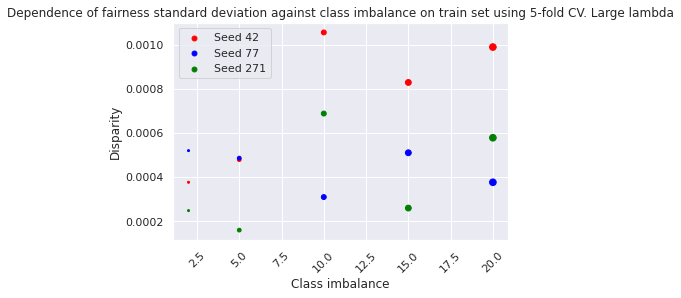

In [ ]:
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in h[42]['train'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in h[42]['train'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in h[42]['train'].items()}).index.fillna(2)), color='red')
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in h[77]['train'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in h[77]['train'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in h[77]['train'].items()}).index.fillna(2)), color='blue')
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in h[271]['train'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in h[271]['train'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in h[271]['train'].items()}).index.fillna(2)), color='green')
plt.xlabel('Class imbalance')
plt.xticks(rotation=45)
plt.ylabel('Disparity')
plt.legend(['Seed 42', 'Seed 77', 'Seed 271'])
plt.title('Dependence of fairness standard deviation against class imbalance on train set using 5-fold CV. Large lambda')
plt.show()

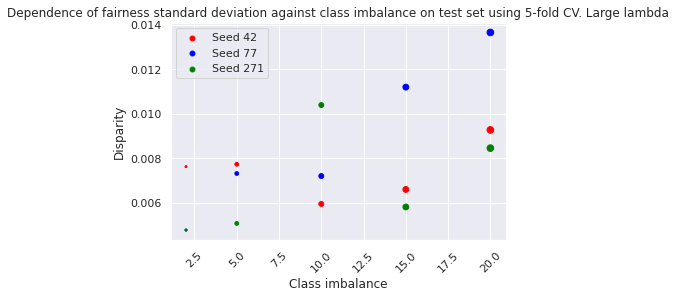

In [ ]:
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in h[42]['test'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in h[42]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in h[42]['test'].items()}).index.fillna(2)), color='red')
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in h[77]['test'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in h[77]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in h[77]['test'].items()}).index.fillna(2)), color='blue')
plt.scatter(pd.Series({k: np.std(v, ddof=1) for k, v in h[271]['test'].items()}).index.fillna(2), pd.Series({k: np.std(v, ddof=1) for k, v in h[271]['test'].items()}).values, s=4+10*np.argsort(pd.Series({k: np.mean(v) for k, v in h[271]['test'].items()}).index.fillna(2)), color='green')
plt.xlabel('Class imbalance')
plt.xticks(rotation=45)
plt.ylabel('Disparity')
plt.legend(['Seed 42', 'Seed 77', 'Seed 271'], loc='best')
plt.title('Dependence of fairness standard deviation against class imbalance on test set using 5-fold CV. Large lambda')
plt.show()

In [ ]:
a1, b1 = save_results(dataset_name='loan_defaults', lamdas=test_lamdas, seeds=test_seeds, downsample_ratio=None)

In [ ]:
c1, d1 = save_results(dataset_name='loan_defaults', lamdas=test_lamdas, seeds=test_seeds, downsample_ratio=10)

In [ ]:
e1, f1 = save_imbalance_results(dataset_name='loan_defaults', downsample_ratios=test_downsample_ratios, lamda=0.1, seeds=test_seeds)

In [ ]:
g1, h1 = save_imbalance_results(dataset_name='loan_defaults', downsample_ratios=test_downsample_ratios, lamda=50, seeds=test_seeds)

In [ ]:
pca_param_dict = {'alpha':1e3, 'eta':1e-3, 'gamma':0, 'weighting':'uniform', 'max_iter':300, 'verbose':False}
loans_PCA = get_dynamics(dataset_name='loan_defaults', method='PCA', params=pca_param_dict)

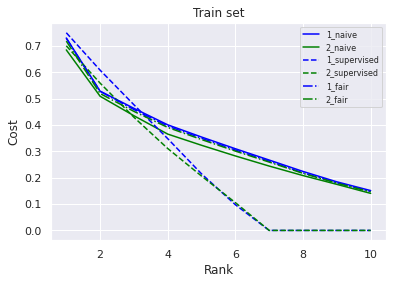

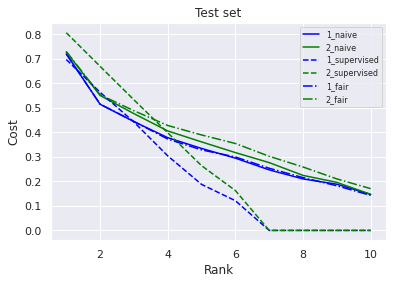

In [ ]:
plot_dynamics(loans_PCA)

In [ ]:
kmeans_param_dict = {'n_init':1, 'alpha':1e3, 'eta':1e-1, 'weighting':'uniform', 'max_iter':300, 'verbose':False}
loans_kmeans = get_dynamics(dataset_name='loan_defaults', method='KMeans', params=kmeans_param_dict)

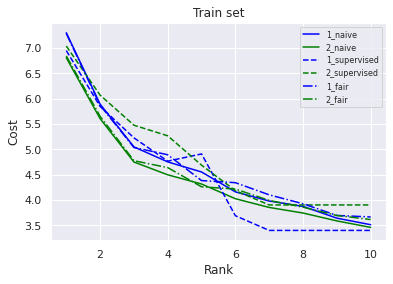

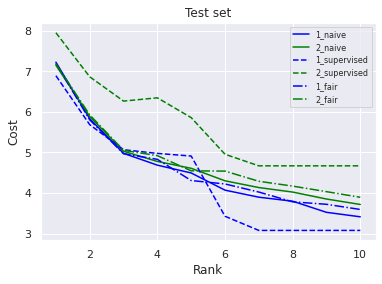

In [ ]:
plot_dynamics(loans_kmeans)

In [ ]:
def compare_to_exist_orthogonal(my_data, my_protected, method, params):
    
    all_results = {}
    all_results['naive'] = {}
    all_results['fair'] = {}
    for rank in range(1, 4):
        all_results['naive'][rank] = {}

        if method == 'PCA':
            all_results['fair'][rank] = {}
            fair_obj = FairPCAOrthogonal(rank=rank, **params)
            all_results['fair'][rank]['test'] = fair_obj.score(my_data, my_protected)
            all_results['fair'][rank]['train'] = fair_obj.train_scores
            cost = np.sum(np.mean(np.dot(fair_obj.X, fair_obj.Y) * np.tile((fair_obj._protected_numeric - fair_obj._protected_numeric.mean()), (fair_obj.Y.shape[1], 1)).T, axis=0) ** 2)
            all_results['fair'][rank]['train']['orth'] = all_results['fair'][rank]['test']['orth'] = cost

            pc = PCA(n_components=rank)
            pc.fit(my_data)
            V = pc.components_

            lm = LinearRegression(fit_intercept=False)
            lm.fit(V.T, my_data.T)
            X = lm.coef_

            all_results['naive'][rank]['train'] = {}
            all_results['naive'][rank]['test'] = {}

            for val in np.unique(my_protected):
                mask = my_protected == val
                all_results['naive'][rank]['train'][val] =\
                all_results['naive'][rank]['test'][val] =\
                      np.mean(np.mean((np.dot(X[mask], V) - my_data[mask])**2))
                
            all_results['naive'][rank]['train']['loss'] =\
            all_results['naive'][rank]['test']['loss'] =\
                      np.mean(np.mean((np.dot(X, V) - my_data)**2))

            all_results['naive'][rank]['train']['orth'] =\
            all_results['naive'][rank]['test']['orth'] =\
                      np.sum(np.mean(np.dot(X, V) * np.tile((fair_obj._protected_numeric - fair_obj._protected_numeric.mean()), (V.shape[1], 1)).T, axis=0) ** 2)
            
        elif method == 'KMeans':
            
            km = KMeans(n_clusters=rank)
            km.fit(my_data)
            dist = find_cost(my_data, my_protected, km.labels_) 
            all_results['naive'][rank]['train'] = dist 
            all_results['naive'][rank]['test'] = dist
            all_results['naive'][rank]['train']['loss'] = km.inertia_ / my_data.shape[0]
            all_results['naive'][rank]['test']['loss'] = km.inertia_ / my_data.shape[0]
            
            fair_obj = FairKMeans(n_clusters=rank, **params)
            all_results['fair'][rank] = fair_obj.score(my_data, my_protected)

        else:
            raise ValueError('Method is not recognized {}'.format(method))
    
    return all_results

In [ ]:
df = scipy.io.loadmat('/content/drive/MyDrive/FairML/fair k-means/adult_4_20_2020.mat')
protected_feature = df['svar'].flatten()
data = df['data']

In [ ]:
sc = StandardScaler()
data_new = sc.fit_transform(data)

In [ ]:
pca_param_dict = {'alpha':1e4, 'eta':3e-4, 'gamma':0, 'weighting':'uniform', 'max_iter':300, 'tol':1e-6, 'mu':0, 'verbose':False, 'test_size':0., 'seed':43}

In [ ]:
pca_param_dict_nonfair = {'alpha':1e-5, 'eta':3e-4, 'gamma':0, 'weighting':'empirical', 'max_iter':300, 'mu':1e5, 'tol':1e-6, 'verbose':False, 'test_size':0., 'seed':43}

In [ ]:
pca_param_dict_nonfair_orth = {'alpha':1e-5, 'eta':1e-3, 'gamma':0, 'weighting':'empirical', 'max_iter':300, 'mu':0, 'tol':1e-6, 'verbose':False, 'test_size':0., 'seed':43}

In [ ]:
class FairPCAOrthogonal(object):
    
    def __init__(self, rank, alpha, eta, weighting='uniform', gamma=0.05, max_iter=500, test_size=0.2, tol=1e-5, mu=1e5, verbose=False, seed=42, decay=0.99):
        
        self.rank = rank
        self.alpha = alpha
        self.eta = eta
        self.gamma = gamma
        self.max_iter = max_iter 
        self.test_size = test_size
        self.tol = tol
        self.verbose = verbose
        self.weighting = weighting
        self.mu = mu
        self.seed = seed
        self.decay = decay
    

    def fit(self, A):
        
        m, n = A.shape
        rng = np.random.RandomState(self.seed)
        self.X = rng.rand(m, self.rank) / np.sqrt(self.rank * m)
        self.Y = rng.rand(self.rank, n) / np.sqrt(self.rank * n)

        curr_iter = 0
        curr_tol = 1e8
        total_loss = []

        mask_dct = {}
        weights = np.zeros(len(self.unique_protected))
        for j, val in enumerate(self.unique_protected):
            
            mask_dct[val] = self.protected_attr == val
            if self.weighting=='empirical':
                weights[j] = np.sum(mask_dct[val]) / m
            elif self.weighting=='uniform':
                weights[j] = 1 / len(self.unique_protected)
            else:
                raise ValueError('did not recognize weighting scheme {}'.format(self.weighting))

        demean_protected = self._protected_numeric - self._protected_numeric.mean()
        tiled_array = np.tile(demean_protected, (self.rank, 1)).T
        lr = self.eta

        while (curr_iter < self.max_iter) and (curr_tol > self.tol):

            variances = np.zeros(len(self.unique_protected))
            for j, val in enumerate(self.unique_protected):
                variances[j] = np.mean(np.mean((np.dot(self.X[mask_dct[val]], self.Y) - A[mask_dct[val]])**2))
            max_variance = np.max(variances)

            denominator = np.sum(weights * np.exp(self.alpha * (variances - max_variance)))
            scalars = weights * np.exp(self.alpha * (variances - max_variance)) / denominator

            gradientX = np.zeros_like(self.X)
            oldX = np.copy(self.X)
            # first we update X given fixed Y
            for j, val in enumerate(self.unique_protected):
                gradientX[mask_dct[val]] = 2 * scalars[j] * np.dot((np.dot(self.X[mask_dct[val]], self.Y) - A[mask_dct[val]]), self.Y.T) + 2 * self.gamma * self.X[mask_dct[val]] 
            
            Xs = np.mean(self.X * tiled_array, axis=0)
            #for i in range(m):
            #    gradientX[i, :] += self.mu * sum( (2 * np.dot(self.Y[:, j], Xs) * self.Y[:, j] * demean_protected[i] / m) for j in range(n) )
            cy_sum = np.sum(np.tile(np.dot(Xs, self.Y), (self.rank, 1)) * self.Y, axis=1)
            gradientX += 2 / m * self.mu * cy_sum * tiled_array

            self.X -= lr * gradientX

            oldY = np.copy(self.Y)
            gradientY = np.zeros_like(self.Y)
            for j, val in enumerate(self.unique_protected):
                gradientY += 2 * scalars[j] * np.dot(self.X[mask_dct[val]].T, (np.dot(self.X[mask_dct[val]], self.Y) - A[mask_dct[val]])) + 2 * self.gamma * self.Y
            
            Xs = np.mean(self.X * tiled_array, axis=0)
            gradientY += 2 * self.mu * np.tile(np.dot(Xs, self.Y), (self.rank, 1)) * np.tile(Xs, (n, 1)).T

            self.Y -= lr * gradientY
            lr *= self.decay

            curr_loss = max_variance + 1/self.alpha * np.log(denominator) + self.gamma * (np.sum(self.X ** 2) + np.sum(self.Y ** 2))
            total_loss.append(curr_loss)
            curr_tol = np.maximum(np.sqrt(np.mean((self.X - oldX)**2)), np.sqrt(np.mean((self.Y - oldY)**2)))

            if self.verbose:
                if curr_iter % 10 == 0:
                    print("Current iteration: {}, Cost per protected group: {}, Tolerance: {}, Orthogonality: {}".format(curr_iter, variances, curr_tol, np.sum((np.dot(Xs, self.Y))**2)))
            curr_iter += 1
 
        self.Y = (self.Y.T / np.sqrt(np.sum(self.Y**2, axis=1))).T
        lm = LinearRegression(fit_intercept=False)
        lm.fit(self.Y.T, A.T)
        self.X = lm.coef_

        resulting_scores = {}
        for j, val in enumerate(self.unique_protected):
            resulting_scores[val] = variances[j]
        resulting_scores['loss'] = np.mean(np.mean((np.dot(self.X, self.Y) - A)**2))

        for j, val in enumerate(self.unique_protected):
            variances[j] = np.mean(np.mean((np.dot(self.X[mask_dct[val]], self.Y) - A[mask_dct[val]])**2))
        print("Last iteration: {}, Cost per cluster: {}".format(curr_iter, variances))

        self.total_loss_ = total_loss
        self.scalars = scalars
        self.weights = weights
        self.variances = variances
        self.train_scores = resulting_scores

        return             

    def predict(self, A, protected_attr):

      
        lm = LinearRegression(fit_intercept=False)
        lm.fit(self.Y.T, A.T)
        newX = lm.coef_

        return newX

    def sample_split(self, A, protected_attr):

        if self.test_size == 0.:
            A_train, A_test, protected_train, protected_test = A, A, protected_attr, protected_attr
        else:
            A_train, A_test, protected_train, protected_test = \
              train_test_split(A, protected_attr, test_size=self.test_size, shuffle=True, random_state=self.seed, stratify=protected_attr)
        
        return A_train, A_test, protected_train, protected_test

    def score(self, A, protected_attr):
        
        A_train, A_test, protected_train, protected_test = self.sample_split(A, protected_attr)
        self.protected_attr = protected_train
        self.unique_protected = set(self.protected_attr)

        if protected_train.dtype == np.dtype('O'):
            ord_enc = OrdinalEncoder()
            ord_enc.fit(protected_train.values.reshape(-1, 1))
            #self._protected_numeric = pd.Series(data=ord_enc.transform(protected_train.values.reshape(-1, 1)).flatten(), name=self.protected_attr.name)
            self._protected_numeric = ord_enc.transform(protected_train.values.reshape(-1, 1)).flatten()
        else:
            #self._protected_numeric = self.protected_attr.copy()
            self._protected_numeric = self.protected_attr.values
            
        self.fit(A_train)
        X_test = self.predict(A_test, protected_test)

        resulting_scores = {}
        for j, val in enumerate(self.unique_protected):
            mask = protected_test == val
            resulting_scores[val] = np.mean(np.mean((np.dot(X_test[mask], self.Y) - A_test[mask])**2))
        resulting_scores['loss'] = np.mean(np.mean((np.dot(X_test, self.Y) - A_test)**2))

        return resulting_scores

In [ ]:
COLOURS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',  '#e377c2']
FLATTEN_COLOURS = [x for i in range(5) for x in COLOURS]

In [ ]:
#credit_PCA = compare_to_exist_orthogonal(pd.DataFrame(data_new), pd.Series(protected_feature), 'PCA', pca_param_dict)
#adult_PCA = compare_to_exist_orthogonal(pd.DataFrame(data_new), pd.Series(protected_feature), 'PCA', pca_param_dict)
lfw_PCA = compare_to_exist_orthogonal(pd.DataFrame(data_new), pd.Series(protected_feature), 'PCA', pca_param_dict)
#credit_PCA_non = compare_to_exist_orthogonal(pd.DataFrame(data_new), pd.Series(protected_feature), 'PCA', pca_param_dict_nonfair)
#adult_PCA_non = compare_to_exist_orthogonal(pd.DataFrame(data_new), pd.Series(protected_feature), 'PCA', pca_param_dict_nonfair)
#lfw_PCA_non = compare_to_exist_orthogonal(pd.DataFrame(data_new), pd.Series(protected_feature), 'PCA', pca_param_dict_nonfair)

Last iteration: 44, Cost per cluster: [0.77803964 0.70317474]
Last iteration: 300, Cost per cluster: [0.66814635 0.62925855]
Last iteration: 200, Cost per cluster: [0.55951939 0.52177876]
Last iteration: 300, Cost per cluster: [0.49886193 0.47011506]
Last iteration: 300, Cost per cluster: [0.46792887 0.45105308]
Last iteration: 300, Cost per cluster: [0.440546   0.42728453]
Last iteration: 300, Cost per cluster: [0.42051283 0.41088028]
Last iteration: 300, Cost per cluster: [0.39910567 0.39057048]
Last iteration: 300, Cost per cluster: [0.38364488 0.373725  ]
Last iteration: 300, Cost per cluster: [0.36602381 0.36112856]


In [ ]:
file_tag = 'lfw_pca_fair_zeromu.pickle'
with open('/content/drive/MyDrive/FairML/result_benchmark/{}'.format(file_tag), 'rb') as handle:
    lfw_PCA = pickle.load(handle)

file_tag = 'adult_pca_fair_zeromu.pickle'
with open('/content/drive/MyDrive/FairML/result_benchmark/{}'.format(file_tag), 'rb') as handle:
    adult_PCA = pickle.load(handle)

file_tag = 'credit_pca_fair_zeromu.pickle'
with open('/content/drive/MyDrive/FairML/result_benchmark/{}'.format(file_tag), 'rb') as handle:
    credit_PCA = pickle.load(handle)

file_tag = 'lfw_pca_orthogonal.pickle'
with open('/content/drive/MyDrive/FairML/result_benchmark/{}'.format(file_tag), 'rb') as handle:
    lfw_PCA_non = pickle.load(handle)

file_tag = 'adult_pca_orthogonal.pickle'
with open('/content/drive/MyDrive/FairML/result_benchmark/{}'.format(file_tag), 'rb') as handle:
    adult_PCA_non = pickle.load(handle)

file_tag = 'credit_pca_orthogonal.pickle'
with open('/content/drive/MyDrive/FairML/result_benchmark/{}'.format(file_tag), 'rb') as handle:
    credit_PCA_non = pickle.load(handle)

In [ ]:
file_tag = 'lfw_pca_fair_zeromu.pickle'
with open('/content/drive/MyDrive/FairML/result_benchmark/{}'.format(file_tag), 'wb') as handle:
    pickle.dump(lfw_PCA, handle)

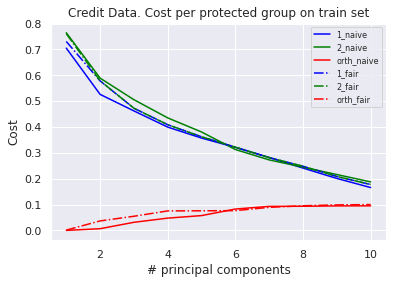

In [ ]:
aa = plot_dynamics(credit_PCA, '# principal components', 'Credit Data. Cost per protected group on')

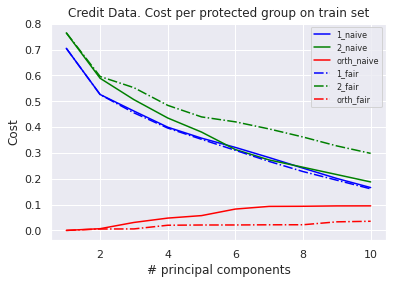

In [ ]:
aa1 = plot_dynamics(credit_PCA_non, '# principal components', 'Credit Data. Cost per protected group on')

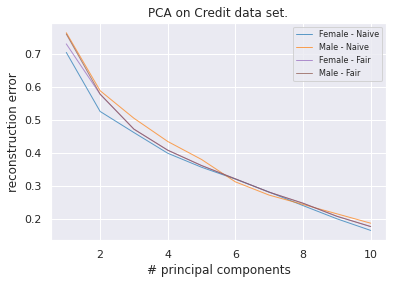

In [ ]:
plt.plot(aa['1_naive'], color=COLOURS[0], alpha=0.7, linewidth=1.)
plt.plot(aa['2_naive'], color=COLOURS[1], alpha=0.7, linewidth=1.)
plt.plot(aa['1_fair'], color=COLOURS[4], alpha=0.7, linewidth=1, linestyle='-')
plt.plot(aa['2_fair'], color=COLOURS[5], alpha=0.7, linewidth=1, linestyle='-')
plt.xlabel('# principal components')
plt.ylabel('reconstruction error')
plt.title('PCA on Credit data set.')
plt.legend(['Female - Naive', 'Male - Naive', 'Female - Fair', 'Male - Fair'], loc='best', prop={'size': 8})
plt.show()

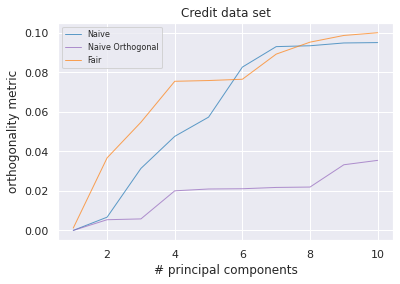

In [ ]:
plt.plot(aa['orth_naive'], color=COLOURS[0], alpha=0.7, linewidth=1.)
plt.plot(aa1['orth_fair'], color=COLOURS[4], alpha=0.7, linewidth=1, linestyle='-')
plt.plot(aa['orth_fair'], color=COLOURS[1], alpha=0.7, linewidth=1.)
plt.xlabel('# principal components')
plt.ylabel('orthogonality metric')
plt.title('Credit data set')
plt.legend(['Naive', 'Naive Orthogonal', 'Fair'], loc='best', prop={'size': 8})
plt.show()

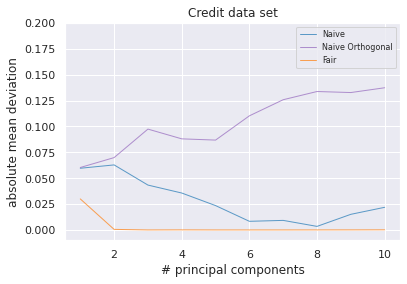

In [ ]:
plt.plot(np.abs(aa['1_naive'] - aa['2_naive']) , color=COLOURS[0], alpha=0.7, linewidth=1.)
plt.plot(np.abs(aa1['1_fair'] - aa1['2_fair']), color=COLOURS[4], alpha=0.7, linewidth=1, linestyle='-')
plt.plot(np.abs(aa['1_fair'] - aa['2_fair']), color=COLOURS[1], alpha=0.7, linewidth=1.)
plt.xlabel('# principal components')
plt.ylabel('absolute mean deviation')
plt.ylim([-0.01, 0.2])
plt.title('Credit data set')
plt.legend(['Naive', 'Naive Orthogonal', 'Fair'], loc='best', prop={'size': 8})
plt.show()

In [ ]:
pca_param_dict = {'alpha':1e3, 'eta':1e-3, 'gamma':0, 'weighting':'uniform', 'max_iter':300, 'tol':1e-6, 'mu':0, 'verbose':False, 'test_size':0., 'seed':42, 'verbose':True}

In [ ]:
adult_PCA2 = compare_to_exist_orthogonal(pd.DataFrame(data_new), pd.Series(protected_feature), 'PCA', pca_param_dict)

Current iteration: 0, Cost per protected group: [1.08116039 0.95975048], Tolerance: 0.012000978066133419, Orthogonality: 1.8893249049300062e-11
Current iteration: 10, Cost per protected group: [1.06209846 0.96000324], Tolerance: 0.2579752338466734, Orthogonality: 0.021975937749125183
Current iteration: 20, Cost per protected group: [1.042442   0.96012066], Tolerance: 0.05091938015428534, Orthogonality: 0.04962376031935781
Current iteration: 30, Cost per protected group: [1.04045477 0.96008761], Tolerance: 0.026364486558370877, Orthogonality: 0.038555466680627176
Current iteration: 40, Cost per protected group: [1.0398548  0.96006781], Tolerance: 0.013857786115723497, Orthogonality: 0.033012963986166
Current iteration: 50, Cost per protected group: [1.03966066 0.96005685], Tolerance: 0.007725633185412664, Orthogonality: 0.03021996778891834
Current iteration: 60, Cost per protected group: [1.0395896  0.96005063], Tolerance: 0.004588879190270668, Orthogonality: 0.02871280983320167
Current

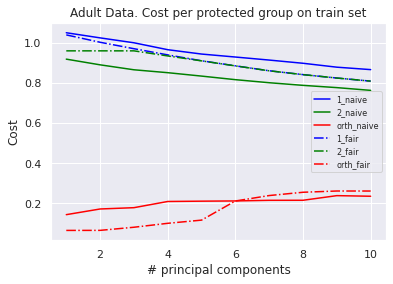

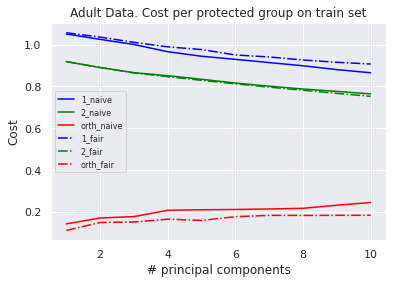

In [ ]:
bb = plot_dynamics(adult_PCA, '# principal components', 'Adult Data. Cost per protected group on')
bb1 = plot_dynamics(adult_PCA_non, '# principal components', 'Adult Data. Cost per protected group on')

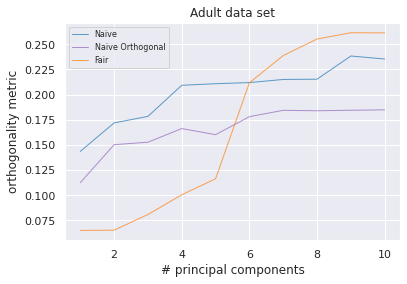

In [ ]:
plt.plot(bb['orth_naive'], color=COLOURS[0], alpha=0.7, linewidth=1.)
plt.plot(bb1['orth_fair'], color=COLOURS[4], alpha=0.7, linewidth=1, linestyle='-')
plt.plot(bb['orth_fair'], color=COLOURS[1], alpha=0.7, linewidth=1.)
plt.xlabel('# principal components')
plt.ylabel('orthogonality metric')
plt.title('Adult data set')
plt.legend(['Naive', 'Naive Orthogonal', 'Fair'], loc='best', prop={'size': 8})
plt.show()

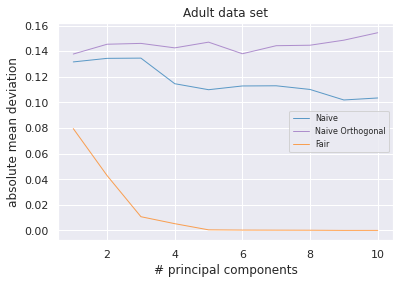

In [ ]:
plt.plot(np.abs(bb['1_naive'] - bb['2_naive']) , color=COLOURS[0], alpha=0.7, linewidth=1.)
plt.plot(np.abs(bb1['1_fair'] - bb1['2_fair']), color=COLOURS[4], alpha=0.7, linewidth=1, linestyle='-')
plt.plot(np.abs(bb['1_fair'] - bb['2_fair']), color=COLOURS[1], alpha=0.7, linewidth=1.)
plt.xlabel('# principal components')
plt.ylabel('absolute mean deviation')
plt.title('Adult data set')
plt.legend(['Naive', 'Naive Orthogonal', 'Fair'], loc='best', prop={'size': 8})
plt.show()

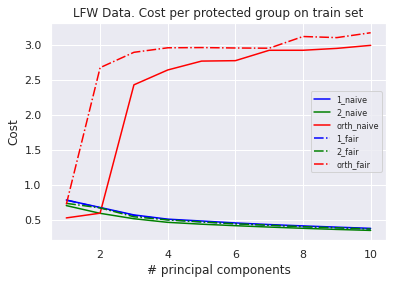

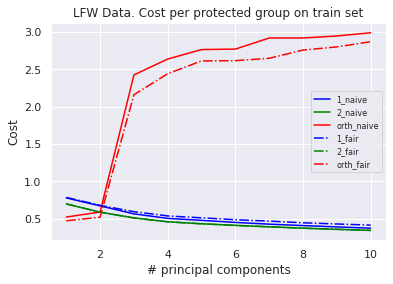

In [ ]:
cc = plot_dynamics(lfw_PCA, '# principal components', 'LFW Data. Cost per protected group on')
cc1 = plot_dynamics(lfw_PCA_non, '# principal components', 'LFW Data. Cost per protected group on')

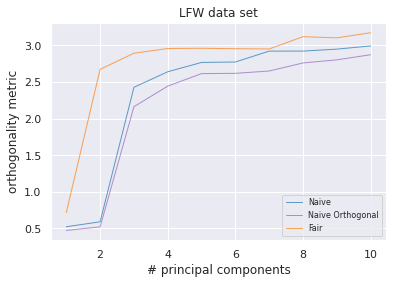

In [ ]:
plt.plot(cc['orth_naive'], color=COLOURS[0], alpha=0.7, linewidth=1.)
plt.plot(cc1['orth_fair'], color=COLOURS[4], alpha=0.7, linewidth=1, linestyle='-')
plt.plot(cc['orth_fair'], color=COLOURS[1], alpha=0.7, linewidth=1.)
plt.xlabel('# principal components')
plt.ylabel('orthogonality metric')
plt.title('LFW data set')
plt.legend(['Naive', 'Naive Orthogonal', 'Fair'], loc='best', prop={'size': 8})
plt.show()

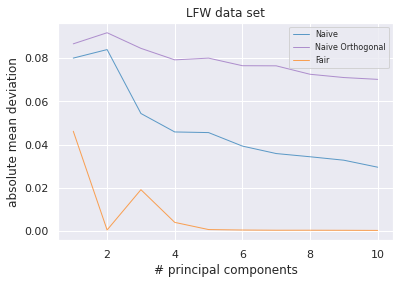

In [ ]:
plt.plot(np.abs(cc['1_naive'] - cc['2_naive']) , color=COLOURS[0], alpha=0.7, linewidth=1.)
plt.plot(np.abs(cc1['1_fair'] - cc1['2_fair']), color=COLOURS[4], alpha=0.7, linewidth=1, linestyle='-')
plt.plot(np.abs(cc['1_fair'] - cc['2_fair']), color=COLOURS[1], alpha=0.7, linewidth=1.)
plt.xlabel('# principal components')
plt.ylabel('absolute mean deviation')
plt.title('LFW data set')
plt.legend(['Naive', 'Naive Orthogonal', 'Fair'], loc='best', prop={'size': 8})
plt.show()

In [ ]:
uncorr_fair_pca = FairPCAOrthogonal(rank=5, alpha=1e-4, eta=1e-3, max_iter=300, mu=1e5, weighting='empirical', decay=0.99, verbose=True, seed=1, test_size=0)

In [ ]:
uncorr_fair_pca.score(pd.DataFrame(data_new), pd.Series(protected_feature))

Current iteration: 0, Cost per protected group: [1.08116281 0.95974919], Tolerance: 0.002610238947790183, Orthogonality: 4.2339961466127606e-11
Current iteration: 10, Cost per protected group: [1.07722666 0.94873678], Tolerance: 0.1579275254363943, Orthogonality: 0.004692053191917457
Current iteration: 20, Cost per protected group: [1.01241738 0.85238393], Tolerance: 0.10798144238377591, Orthogonality: 0.034967826528964574
Current iteration: 30, Cost per protected group: [0.9806388  0.83389726], Tolerance: 0.027370691647784058, Orthogonality: 0.03455324429083319
Current iteration: 40, Cost per protected group: [0.97486783 0.83195461], Tolerance: 0.018852654730795455, Orthogonality: 0.03490721262343915
Current iteration: 50, Cost per protected group: [0.97218078 0.83087179], Tolerance: 0.013579366681014782, Orthogonality: 0.035507014333759794
Current iteration: 60, Cost per protected group: [0.97084113 0.83018196], Tolerance: 0.010048653502152536, Orthogonality: 0.03599698962628086
Curr

{1: 0.964616206135961, 2: 0.8276807167876613, 'loss': 0.873077290300778}

In [ ]:
my_data =pd.DataFrame(data_new)
my_protected = pd.Series(protected_feature)

pc = PCA(n_components=5)
pc.fit(my_data)
V = pc.components_

lm = LinearRegression(fit_intercept=False)
lm.fit(V.T, my_data.T)
X = lm.coef_

variances = []

for val in np.unique(my_protected):
    mask = my_protected == val
    variances.append(np.mean(np.mean((np.dot(X[mask], V) - my_data[mask])**2)))

In [ ]:
np.mean(np.mean((np.dot(X, V) - my_data)**2))

0.8705994419056677

In [ ]:
{1: 0.964616206135961, 2: 0.8276807167876613, 'loss': 0.873077290300778}

In [ ]:
np.sum(np.mean(np.dot(uncorr_fair_pca.X, uncorr_fair_pca.Y) * np.tile((uncorr_fair_pca._protected_numeric - uncorr_fair_pca._protected_numeric.mean()), (103, 1)).T, axis=0) ** 2)

0.16876563986768361

In [ ]:
np.sum(np.mean(np.dot(X, V) * np.tile((uncorr_fair_pca._protected_numeric - uncorr_fair_pca._protected_numeric.mean()), (103, 1)).T, axis=0) ** 2)

0.21073233623051368